## Microsoft Malware Prediction

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

### EDA

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

%matplotlib inline

plt.style.use('ggplot') # haciendo los graficos un poco mas bonitos en matplotlib

# sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [2]:
print(plt.style.available)


['bmh', 'classic', 'dark_background', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', '_classic_test']


In [162]:
%%time

# Change working directory
os.chdir('C:/Users/vfarfan/DS/Ms')
# Load the data
df = pd.read_csv("data/train.csv", dtype={
   'MachineIdentifier':'category', 'ProductName':'category', 'EngineVersion':'category', 'AppVersion':'category',
       'AvSigVersion':'category', 'IsBeta':'int8', 'RtpStateBitfield':'float16', 'IsSxsPassiveMode':'int8',
       'DefaultBrowsersIdentifier':'category', 'AVProductStatesIdentifier':'category',
       'AVProductsInstalled':'float16', 'AVProductsEnabled':'float16', 'HasTpm':'category',
       'CountryIdentifier':'category', 'CityIdentifier':'category', 'OrganizationIdentifier':'category',
       'GeoNameIdentifier':'category', 'LocaleEnglishNameIdentifier':'category', 'Platform':'category',
       'Processor':'category', 'OsVer':'category', 'OsBuild':'int16', 'OsSuite':'int16', 'OsPlatformSubRelease':'category',
       'OsBuildLab':'category', 'SkuEdition':'category', 'IsProtected':'float16', 'AutoSampleOptIn':'int8', 
        'PuaMode':'category',
       'SMode':'float16', 'IeVerIdentifier':'float16', 'SmartScreen':'category', 'Firewall':'float16', 
        'UacLuaenable':'float16',
       'Census_MDC2FormFactor':'category', 'Census_DeviceFamily':'category',
       'Census_OEMNameIdentifier':'category', 'Census_OEMModelIdentifier':'category',
       'Census_ProcessorCoreCount':'float16', 'Census_ProcessorManufacturerIdentifier':'category',
       'Census_ProcessorModelIdentifier':'category', 'Census_ProcessorClass':'category',
       'Census_PrimaryDiskTotalCapacity':'float32', 'Census_PrimaryDiskTypeName':'category',
       'Census_SystemVolumeTotalCapacity':'float32', 'Census_HasOpticalDiskDrive':'int16',
       'Census_TotalPhysicalRAM':'float16', 'Census_ChassisTypeName':'category',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches':'float16',
       'Census_InternalPrimaryDisplayResolutionHorizontal':'float16',
       'Census_InternalPrimaryDisplayResolutionVertical':'float16',
       'Census_PowerPlatformRoleName':'category', 'Census_InternalBatteryType':'category',
       'Census_InternalBatteryNmberOfCharges':'float16', 'Census_OSVersion':'category',
       'Census_OSArchitecture':'category', 'Census_OSBranch':'category', 'Census_OSBuildNumber':'int16',
       'Census_OSBuildRevision':'int16', 'Census_OSEdition':'category', 'Census_OSSkuName':'category',
       'Census_OSInstallTypeName':'category', 'Census_OSInstallLanguageIdentifier':'category',
       'Census_OSUILocaleIdentifier':'category', 'Census_OSWUAutoUpdateOptionsName':'category',
       'Census_IsPortableOperatingSystem':'int16', 'Census_GenuineStateName':'category',
       'Census_ActivationChannel':'category', 'Census_IsFlightingInternal':'float16',
       'Census_IsFlightsDisabled':'float16', 'Census_FlightRing':'category',
       'Census_ThresholdOptIn':'float16', 'Census_FirmwareManufacturerIdentifier':'category',
       'Census_FirmwareVersionIdentifier':'category', 'Census_IsSecureBootEnabled':'int16',
       'Census_IsWIMBootEnabled':'float16', 'Census_IsVirtualDevice':'float16',
       'Census_IsTouchEnabled':'int16', 'Census_IsPenCapable':'int16',
       'Census_IsAlwaysOnAlwaysConnectedCapable':'float16', 'Wdft_IsGamer':'float16',
       'Wdft_RegionIdentifier':'category', 'HasDetections':'int16'
}
#     , nrows=1000000, low_memory=False
)
print('Dimensiones: ',df.shape)
df.size

Dimensiones:  (8921483, 83)
Wall time: 4min 15s


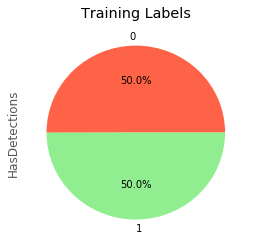

In [163]:
colors = ['tomato','lightgreen']

df['HasDetections'].value_counts().plot.pie(figsize=(4,4), autopct='%1.1f%%', colors=colors)
plt.title('Training Labels')
plt.show()

## Tipos de variables

In [164]:
numeric = df._get_numeric_data().columns

true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

binary_variables = [c for c in df.columns if df[c].nunique() == 2]
categorical_columns = [c for c in df.columns if (c not in true_numerical_columns) & (c not in binary_variables)]

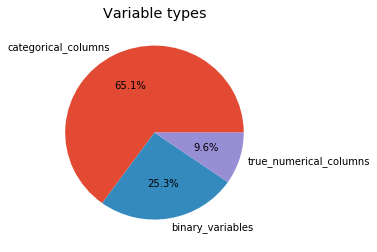

In [165]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}

plt.figure(figsize=(4,4))
plt.title('Variable types')

plt.pie(labels=list(variables.keys()), x=list(variables.values()), autopct='%1.1f%%')
plt.show()

## Análisis de cada variable

Creo un dataframe para ir guardando las variables procesadas.

In [7]:
# dfproc = pd.DataFrame(df['HasDetections'], columns=['HasDetections'], index=df['MachineIdentifier'])
# dfproc.shape
# dfproc = 0

#### MachineIdentifier
Un registro por cada identificador

In [8]:
print('Cantidad de casos: ', df['MachineIdentifier'].nunique())

Cantidad de casos:  8921483


#### Eliminar columnas con valores constantes
Elimino columnas con valores constantes o con sólo dos valores pero uno de ellos con muy poca frecuencia

In [9]:
# for feat in df.columns:
#     if (len(df[feat].value_counts()) <= 2):
#         print(df[feat].value_counts())

# df = df.drop('IsBeta', axis=1)
# df = df.drop('AutoSampleOptIn', axis=1)
# df = df.drop('PuaMode', axis=1)
# df = df.drop('Census_IsFlightingInternal', axis=1)
# df = df.drop('Census_IsFlightsDisabled', axis=1)
# df = df.drop('Census_IsWIMBootEnabled', axis=1)

### Funciones

In [10]:
# Función para describir variables
def describir(var, vc=False):
    tipo = df[var].dtypes.name
    
    print('Tipo de dato: ', tipo)
    if tipo == 'category':
        print('Valores únicos: ', df[var].nunique())
        print('Valores nulos: ', sum(df[var].isnull()))
        print('Porcentaje de valores nulos: %s%%' % (sum(df[var].isnull())/len(df[var]) * 100))
        if vc:
            print('\n')
            print(df[var].value_counts())
    else:
        print('nada')

# Función para graficar variables
def plot_vars(var1, var2, h=False, cols=True, data=df):
    if cols:
        r=1; c=2; fs=(14,3)
    else:
        r=2; c=1; fs=(14,6)
        
    plt.figure(figsize=fs)
    plt.subplot(r,c,1)
    plt.xticks(rotation=45)
    plt.title(var1)
    if h:
        sns.countplot(y=var1, data=data)
    else:
        sns.countplot(x=var1, data=data)
    plt.subplot(r,c,2)
    plt.xticks(rotation=45)
    plt.title(var2)
    if h:
        sns.countplot(y=var1, data=data, hue=var2, palette=colors)
    else:
        sns.countplot(x=var1, data=data, hue=var2, palette=colors)
    plt.tight_layout()
    plt.show()

#### ProductName
Defender state information e.g. win8defender
- Eliminar casos poco frecuentes?
- One Hot Encoding para las dos más frecuentes?

Tipo de dato:  category
Valores únicos:  6
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


win8defender     8826520
mse                94873
mseprerelease         53
scep                  22
windowsintune          8
fep                    7
Name: ProductName, dtype: int64


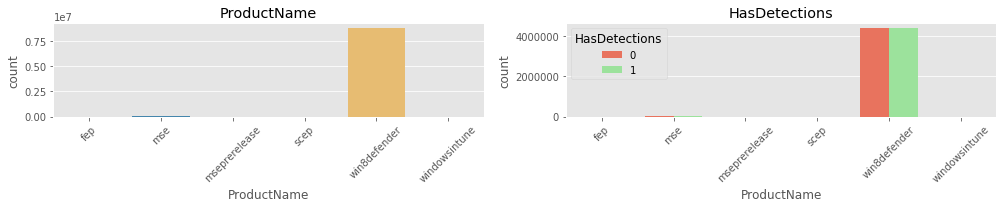

In [11]:
describir('ProductName', vc=True)
plot_vars('ProductName','HasDetections', data=df)

#### EngineVersion
- 'Other' for unfrequent categories
- Analysis for each part of code

Tipo de dato:  category
Valores únicos:  70
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


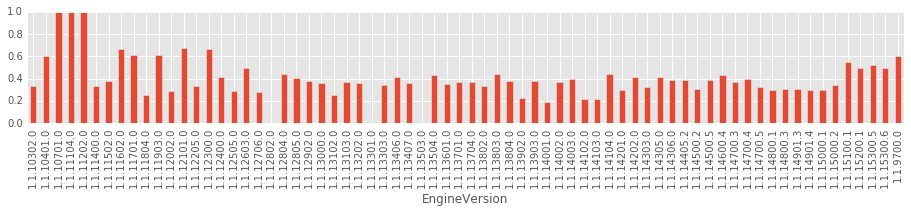

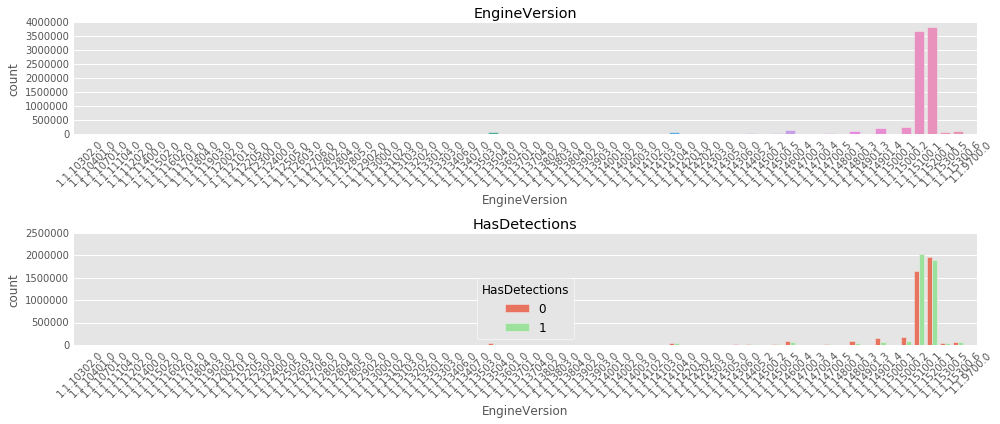

In [108]:
describir('EngineVersion')
plt.figure(figsize=(14,2))
df.groupby('EngineVersion')['HasDetections'].mean().plot.bar()

plot_vars('EngineVersion','HasDetections', cols=False, data=df)

Categories:  63


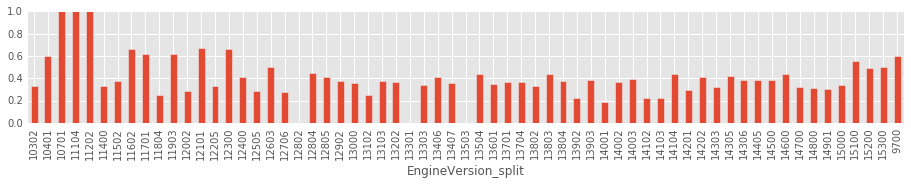

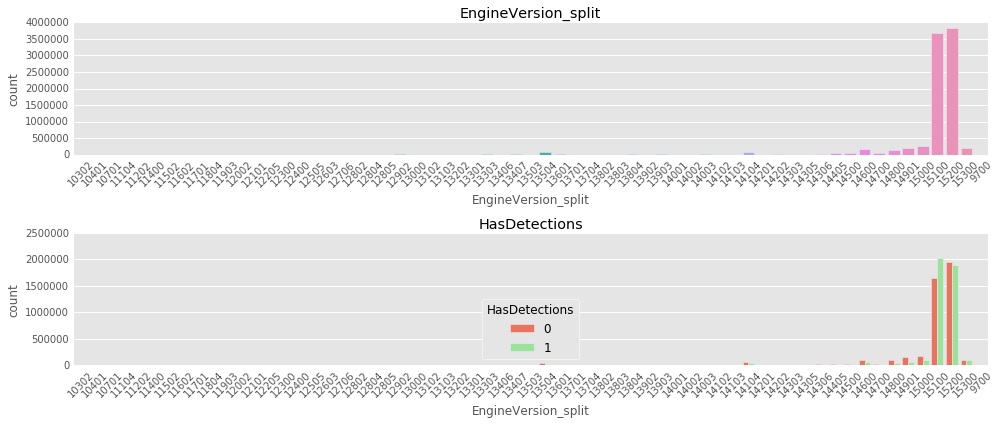

In [112]:
d = df
d['EngineVersion_split'] = d['EngineVersion'].str.split('.').str.get(2)
print('Categories: ', d['EngineVersion_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('EngineVersion_split')['HasDetections'].mean().plot.bar()

plot_vars('EngineVersion_split','HasDetections', cols=False, data=d)



In [114]:
dfproc['EngineVersion_split'] = d['EngineVersion_split']

Categories:  7


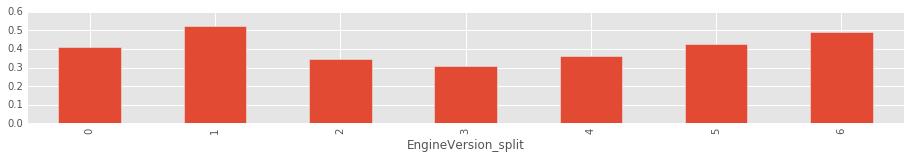

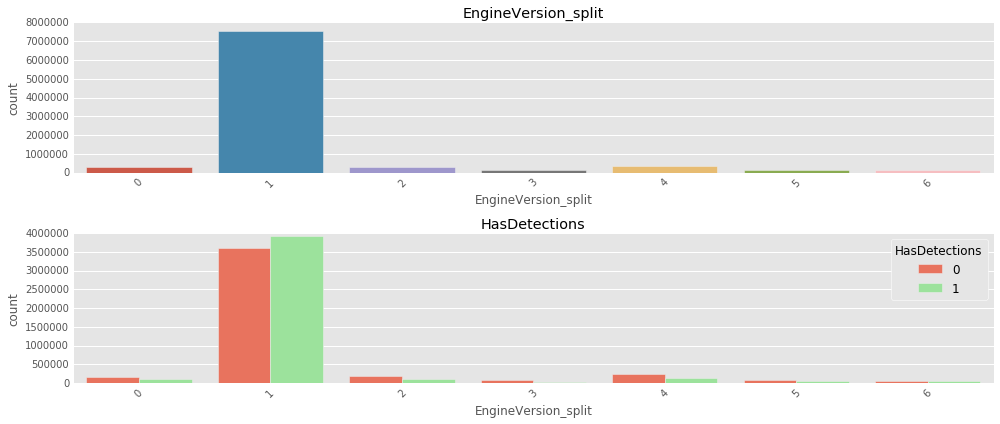

In [115]:
d = df
d['EngineVersion_split'] = d['EngineVersion'].str.split('.').str.get(3)
print('Categories: ', d['EngineVersion_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('EngineVersion_split')['HasDetections'].mean().plot.bar()

plot_vars('EngineVersion_split','HasDetections', cols=False, data=d)

In [116]:
dfproc['EngineVersion_split2'] = d['EngineVersion_split']

#### AppVersion
- 'Other' for unfrequent values
- Patterns in code

Tipo de dato:  category
Valores únicos:  110
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


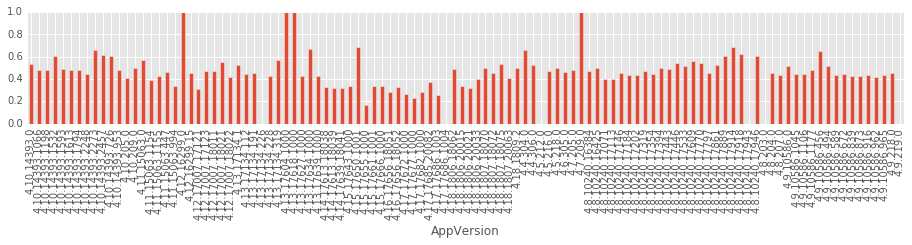

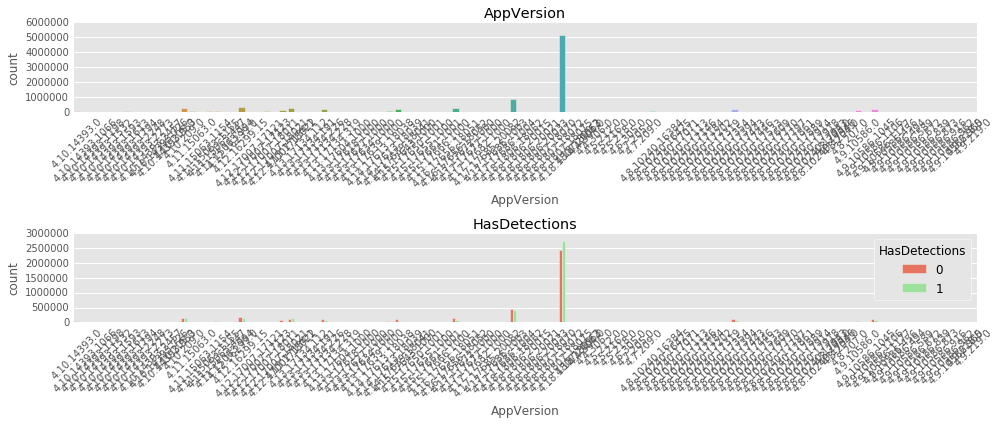

In [117]:
describir('AppVersion')

plt.figure(figsize=(14,2))
df.groupby('AppVersion')['HasDetections'].mean().plot.bar()

plot_vars('AppVersion','HasDetections', cols=False, data=df)

Mirando el segundo número del código de la versión:
- Tiene más positivos que negativos el 18
- Se puede unir categorías poco frecuentes

Categories:  15


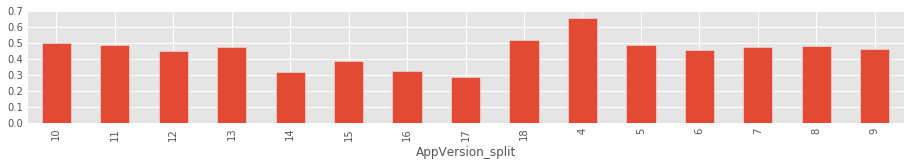

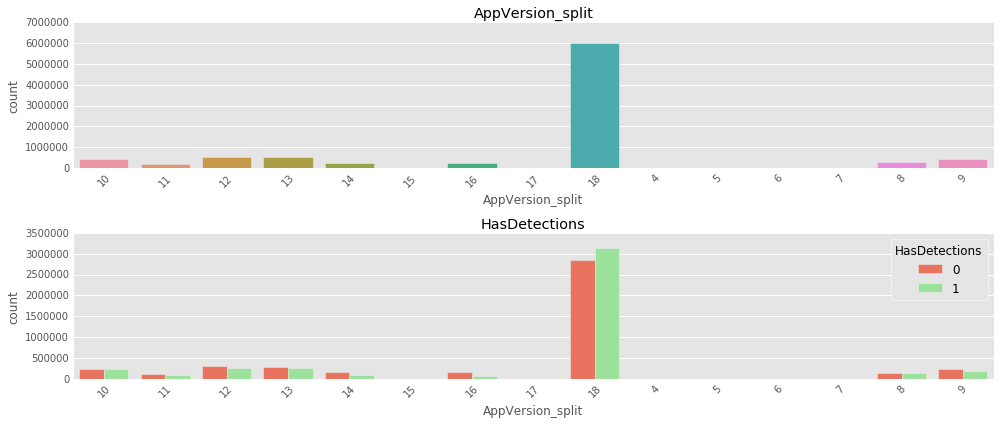

In [122]:
d = df
d['AppVersion_split'] = d['AppVersion'].str.split('.').str.get(1)
print('Categories: ', d['AppVersion_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('AppVersion_split')['HasDetections'].mean().plot.bar()

plot_vars('AppVersion_split','HasDetections', cols=False, data=d)

In [123]:
dfproc['AppVersion_split'] = d['AppVersion_split']

Mirando el tercer número del código de la versión:
- Tiene más positivos que negativos el 1807
- Se puede unir categorías poco frecuentes

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Categories:  39


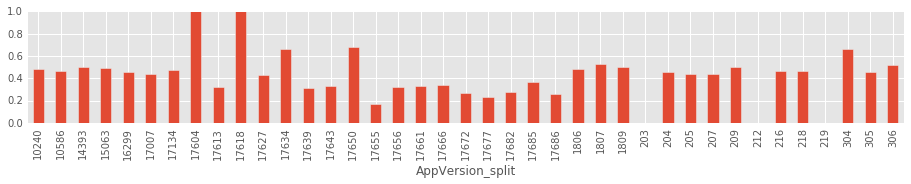

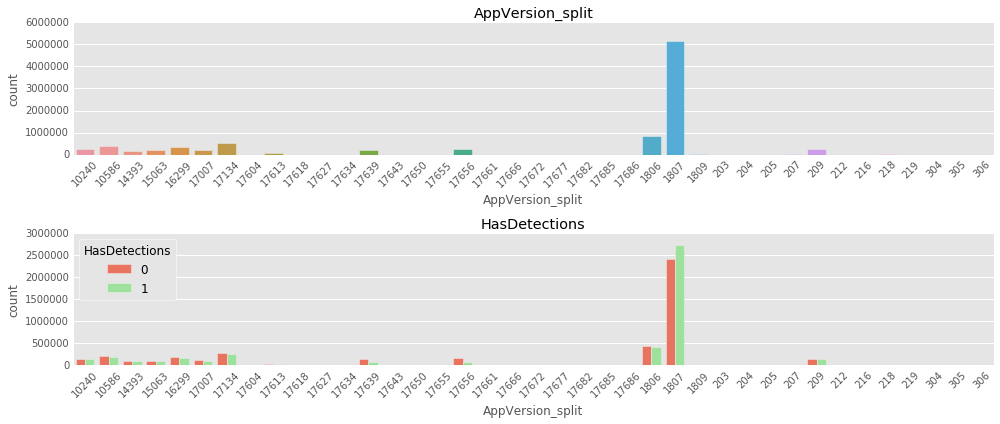

In [124]:
d = df[['AppVersion','HasDetections']]
d['AppVersion_split'] = d['AppVersion'].str.split('.').str.get(2)
print('Categories: ', d['AppVersion_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('AppVersion_split')['HasDetections'].mean().plot.bar()

plot_vars('AppVersion_split','HasDetections', cols=False, data=d)

In [125]:
dfproc['AppVersion_split2'] = d['AppVersion_split']

Mirando el cuarto número del código de la versión:
- Tiene más positivos que negativos el 18072.  0 y 1 también.
- Se puede unir categorías poco frecuentes

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Categories:  81


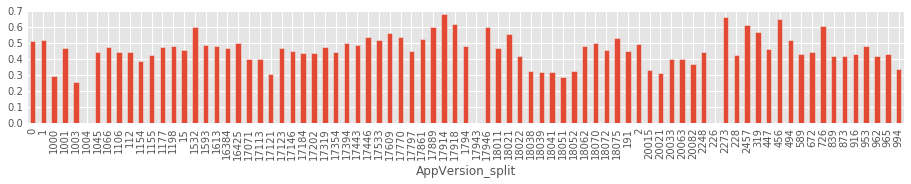

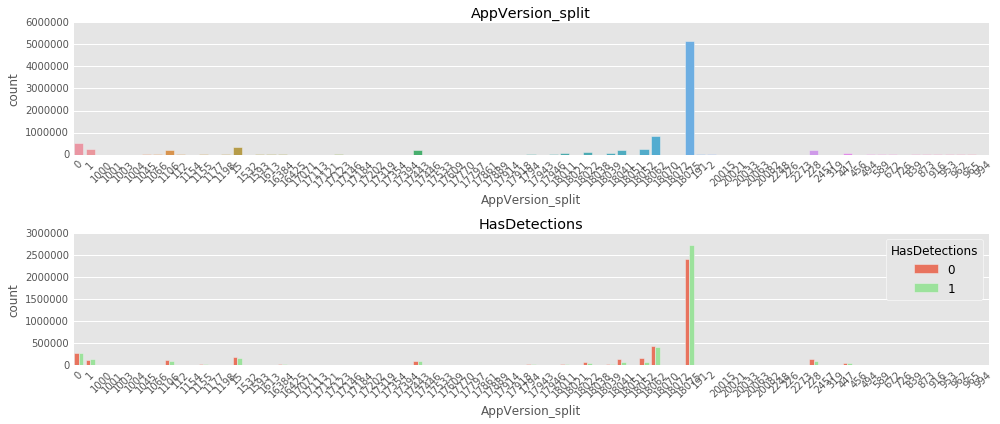

In [126]:
d = df[['AppVersion','HasDetections']]
d['AppVersion_split'] = d['AppVersion'].str.split('.').str.get(3)
print('Categories: ', d['AppVersion_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('AppVersion_split')['HasDetections'].mean().plot.bar()

plot_vars('AppVersion_split','HasDetections', cols=False, data=d)

In [127]:
dfproc['AppVersion_split3'] = d['AppVersion_split']

#### AvSigVersion
Mirando el segundo número del código de la versión:
- Tiene más positivos que negativos el 273.
- Se puede unir categorías poco frecuentes


In [128]:
describir('AvSigVersion')

Tipo de dato:  category
Valores únicos:  8531
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Categories:  51


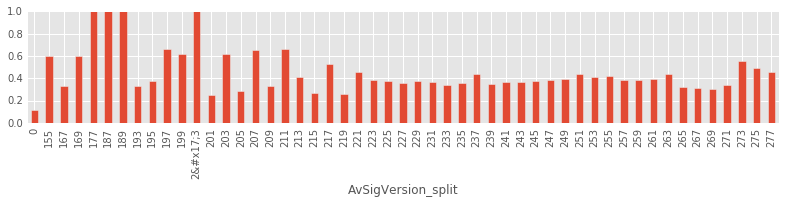

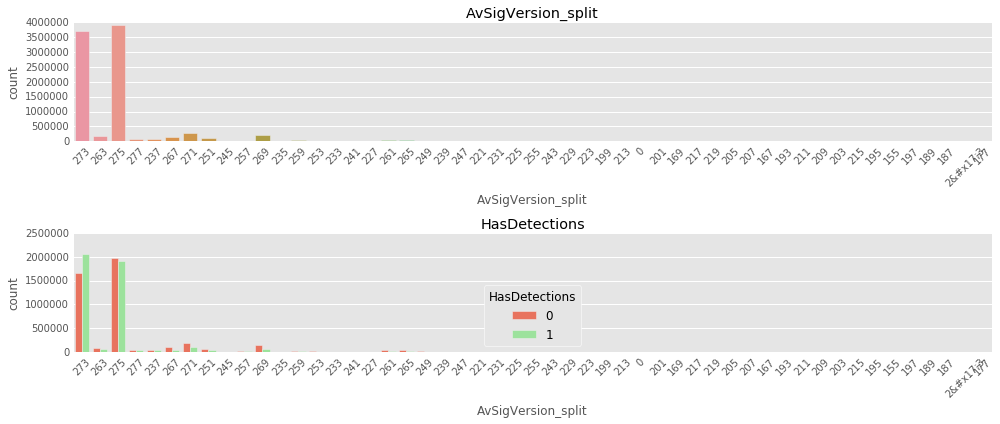

In [129]:
d = df[['AvSigVersion','HasDetections']]
d['AvSigVersion_split'] = d['AvSigVersion'].str.split('.').str.get(1)
print('Categories: ', d['AvSigVersion_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('AvSigVersion_split')['HasDetections'].mean().plot.bar()

plot_vars('AvSigVersion_split','HasDetections', cols=False, data=d)

In [130]:
dfproc['AvSigVersion_split'] = d['AvSigVersion_split']

Sólo para 273, miro el tercer número.  Analizar.

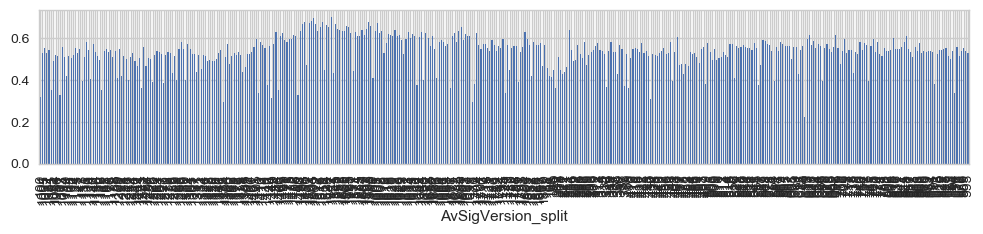

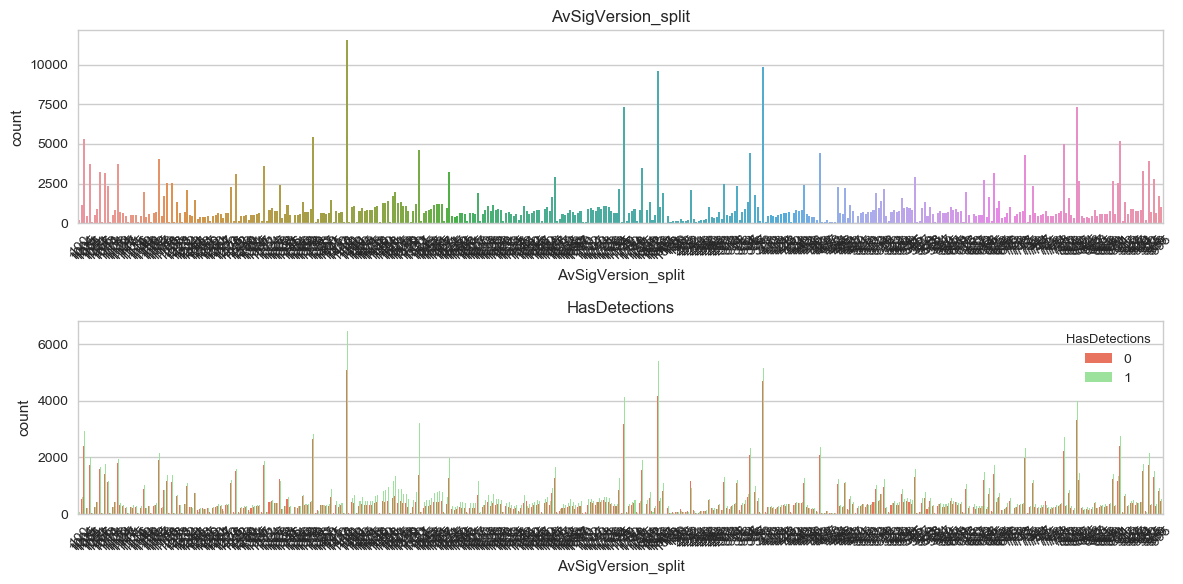

In [35]:
d = df.loc[df['AvSigVersion'].str.split('.').str.get(1) == '273',('AvSigVersion','HasDetections')]
d['AvSigVersion_split'] = d['AvSigVersion'].str.split('.').str.get(2)
# d['AvSigVersion_split'].value_counts()
plt.figure(figsize=(12,2))
d.groupby('AvSigVersion_split')['HasDetections'].mean().plot.bar()

plot_vars('AvSigVersion_split','HasDetections', cols=False, data=d)

#### RtpStateBitfield
- Seis números distintos - categórico o numérico
- Distribución similar de positivos y negativos
- Se puede unir categorías poco frecuentes?


Tipo de dato:  float16
nada


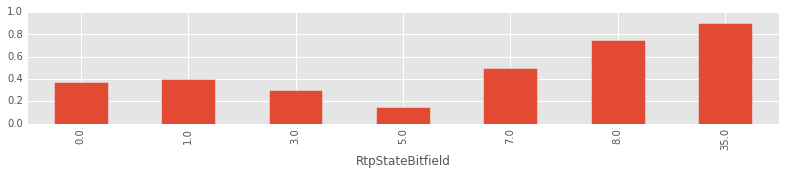

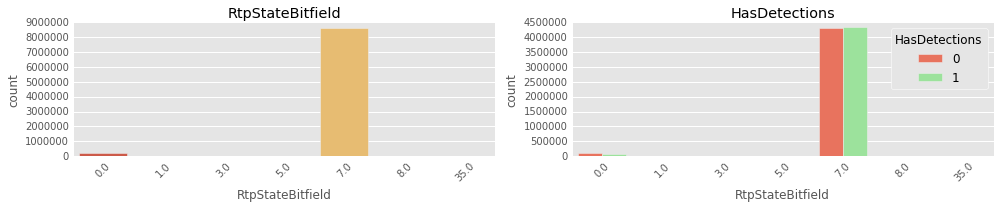

In [131]:
describir('RtpStateBitfield')

plt.figure(figsize=(12,2))
df.groupby('RtpStateBitfield')['HasDetections'].mean().plot.bar()

plot_vars('RtpStateBitfield','HasDetections', cols=True, data=df)

In [166]:
dfproc['RtpStateBitfield'] = df['RtpStateBitfield']

#### IsSxsPassiveMode
- Convertir a boolean?
- Distribución similar de positivos y negativos.  Algunos positivos más cuando es falso, algunos negativos más cuando es verdadero.

Tipo de dato:  int8
nada


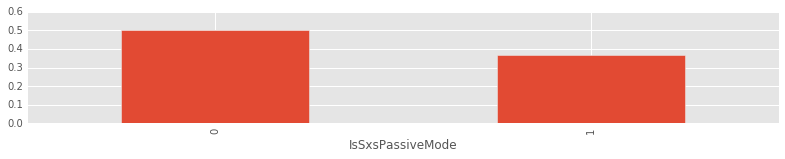

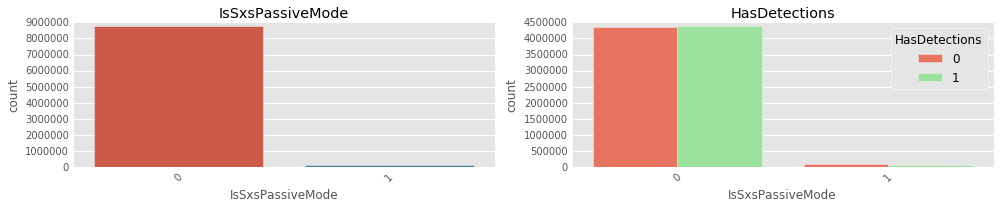

In [132]:
describir('IsSxsPassiveMode', vc=True)

plt.figure(figsize=(12,2))
df.groupby('IsSxsPassiveMode')['HasDetections'].mean().plot.bar()

plot_vars('IsSxsPassiveMode','HasDetections', cols=True, data=df)

In [167]:
dfproc['IsSxsPassiveMode'] = df['IsSxsPassiveMode']

#### DefaultBrowsersIdentifier
- 784 valores únicos
- Es un número entero.  Tratar como numérico o categórico?
- Ver qué categorías se pueden unir?

In [134]:
describir('DefaultBrowsersIdentifier', vc=True)

Tipo de dato:  category
Valores únicos:  2017
Valores nulos:  8488045
Porcentaje de valores nulos: 95.1416373264%


239     46056
3195    42692
1632    28751
3176    24220
146     20756
1910    19416
1727    17393
2064    13990
2725    13338
1160    12594
1536    11306
788     11302
1623    10406
1078    10267
1823     7397
2273     6877
2290     6758
614      6539
2388     6370
773      5900
1622     5332
2168     4975
1161     4891
139      4246
1926     4098
1616     3696
2434     3491
2170     2903
2169     2750
597      2386
        ...  
438         1
2201        1
41          1
2198        1
2197        1
413         1
415         1
419         1
2187        1
429         1
43          1
2180        1
435         1
436         1
439         1
2138        1
44          1
440         1
441         1
217         1
442         1
2162        1
2158        1
445         1
447         1
2152        1
2151        1
451         1
214         1
1972        1
Name: DefaultBrowsersIdentifie

In [1]:
y1 = pd.DataFrame(df['DefaultBrowsersIdentifier'].value_counts().nlargest(20))
means = pd.DataFrame(df.groupby('DefaultBrowsersIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

plt.figure(figsize=(15,2))
y1['DefaultBrowsersIdentifier'].plot.bar()
plt.show()

pd.DataFrame(df['DefaultBrowsersIdentifier'].value_counts(ascending=False)).iloc[1:100,:].plot.line()
plt.show()

NameError: name 'pd' is not defined

In [168]:
dfproc['DefaultBrowsersIdentifier'] = df['DefaultBrowsersIdentifier']

#### AVProductStatesIdentifier
ID for the specific configuration of a user's antivirus software
- 28970 valores únicos, todos numéricos
- Se pueden unir categorías? Tomar los primeros 20 y el resto a other?

In [198]:
describir('AVProductStatesIdentifier')
np.median(df['AVProductStatesIdentifier'].value_counts())

# plt.figure(figsize=(15,2))
# df.groupby('IsSxsPassiveMode')['HasDetections'].mean().plot.bar().values

# plot_vars('IsSxsPassiveMode','HasDetections', cols=True, data=df)

Tipo de dato:  category
Valores únicos:  28970
Valores nulos:  36221
Porcentaje de valores nulos: 0.405997523058%


1.0

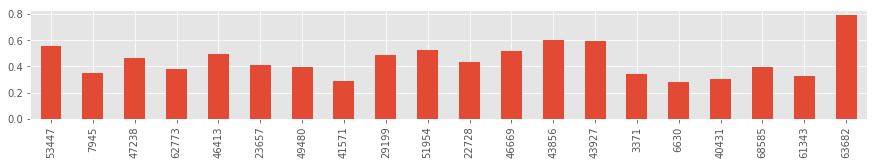

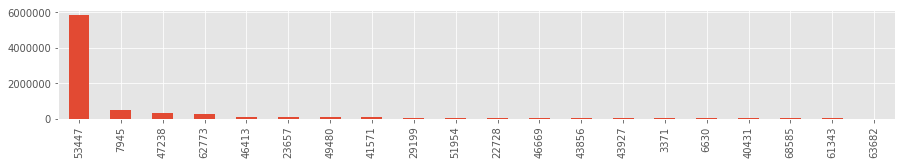

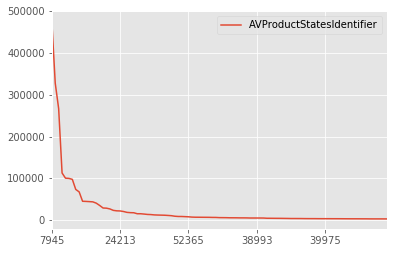

In [71]:
y1 = pd.DataFrame(df['AVProductStatesIdentifier'].value_counts().nlargest(20))
means = pd.DataFrame(df.groupby('AVProductStatesIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

plt.figure(figsize=(15,2))
y1['AVProductStatesIdentifier'].plot.bar()
plt.show()

pd.DataFrame(df['AVProductStatesIdentifier'].value_counts(ascending=False)).iloc[1:100,:].plot.line()
plt.show()

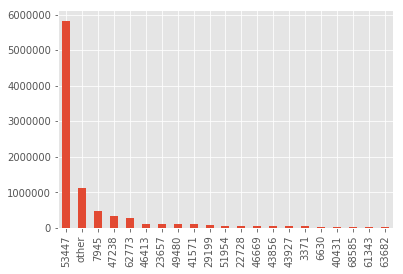

In [85]:
freq = pd.Series(np.where(df['AVProductStatesIdentifier'].isin(y1.index),df['AVProductStatesIdentifier'],'other'))
freq.value_counts().plot.bar()

#### AVProductsInstalled
- Entero del 0 al 7

Tipo de dato:  float16
nada


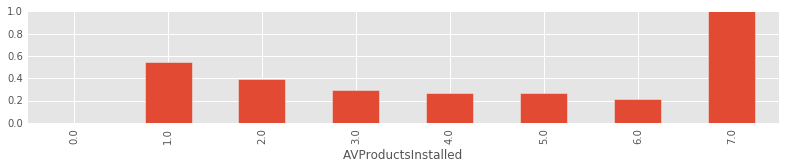

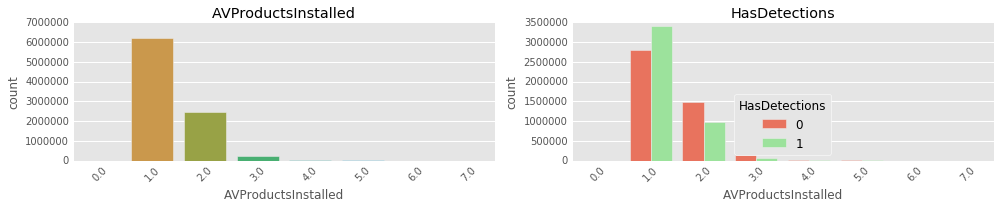

In [247]:
describir('AVProductsInstalled', vc=True)

plt.figure(figsize=(12,2))
df.groupby('AVProductsInstalled')['HasDetections'].mean().plot.bar()

plot_vars('AVProductsInstalled','HasDetections', cols=True, data=df)

#### AVProductsEnabled

Tipo de dato:  float16
nada


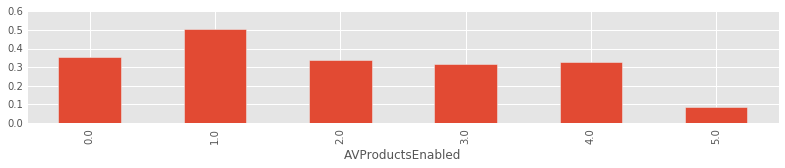

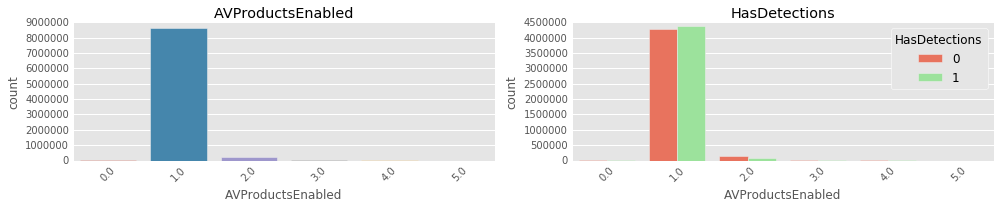

In [248]:
describir('AVProductsEnabled', vc=True)

plt.figure(figsize=(12,2))
df.groupby('AVProductsEnabled')['HasDetections'].mean().plot.bar()

plot_vars('AVProductsEnabled','HasDetections', cols=True, data=df)

In [249]:
dfproc['AVProductsEnabled'] = df['AVProductsEnabled']

#### HasTpm

Tipo de dato:  category
Valores únicos:  2
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


1    8814167
0     107316
Name: HasTpm, dtype: int64


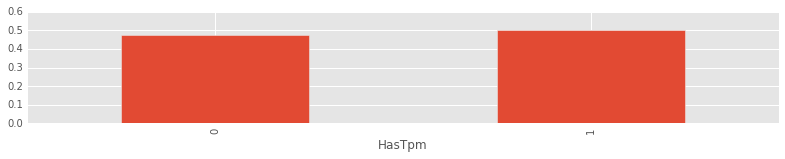

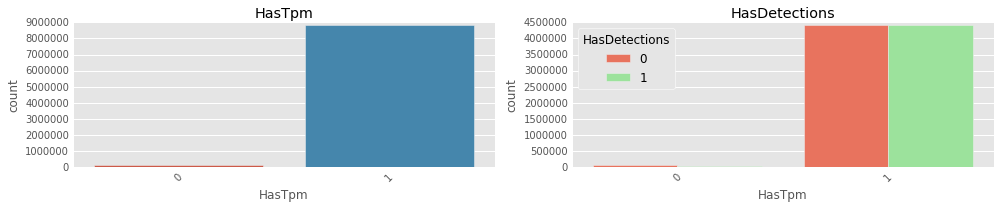

In [251]:
describir('HasTpm', vc=True)

plt.figure(figsize=(12,2))
df.groupby('HasTpm')['HasDetections'].mean().plot.bar()

plot_vars('HasTpm','HasDetections', cols=True, data=df)

#### CountryIdentifier
- 222 valores únicos.
- Números enteros.
- Agrupar categorías poco frecuentes?

In [97]:
describir('CountryIdentifier')

# plt.figure(figsize=(12,2))
# df.groupby('CountryIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('CountryIdentifier','HasDetections', cols=True, data=df)

Tipo de dato:  category
Valores únicos:  222
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


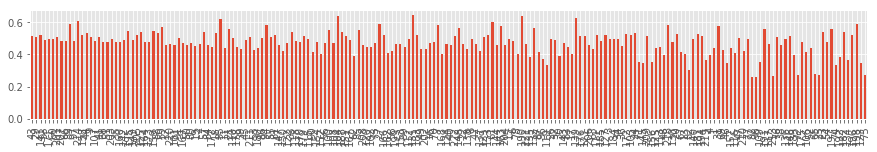

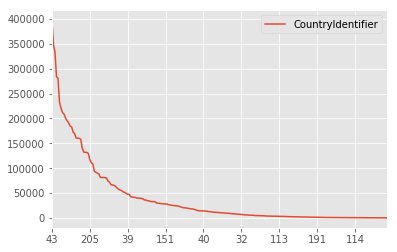

In [98]:
y1 = pd.DataFrame(df['CountryIdentifier'].value_counts().nlargest(200))
means = pd.DataFrame(df.groupby('CountryIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

# plt.figure(figsize=(15,2))
# y1['CountryIdentifier'].plot.bar()
# plt.show()

pd.DataFrame(df['CountryIdentifier'].value_counts(ascending=False)).plot.line()
plt.show()

#### CityIdentifier
- 107366 valores únicos
- Descartar y usar country?
- Ver cuántas ciudades hay por país

In [99]:
describir('CityIdentifier')

# plt.figure(figsize=(12,2))
# df.groupby('CountryIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('CountryIdentifier','HasDetections', cols=True, data=df)

Tipo de dato:  category
Valores únicos:  107366
Valores nulos:  325409
Porcentaje de valores nulos: 3.64747654622%


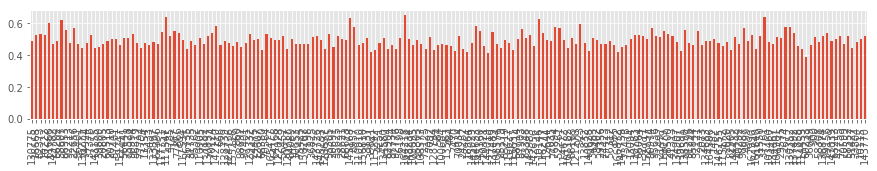

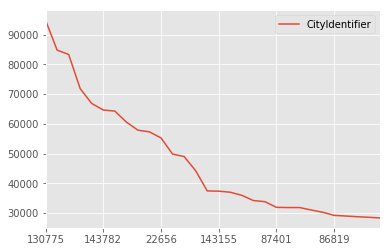

In [105]:
y1 = pd.DataFrame(df['CityIdentifier'].value_counts().nlargest(200))
means = pd.DataFrame(df.groupby('CityIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

# plt.figure(figsize=(15,2))
# y1['CountryIdentifier'].plot.bar()
# plt.show()

pd.DataFrame(df['CityIdentifier'].value_counts(ascending=False)).iloc[:30,:].plot.line()
plt.show()

#### OrganizationIdentifier
- 49 valores únicos. Hay dos que se repiten en la mayoría de los casos
- Agrupar el resto en otros?

Tipo de dato:  category
Valores únicos:  49
Valores nulos:  2751518
Porcentaje de valores nulos: 30.8414867797%


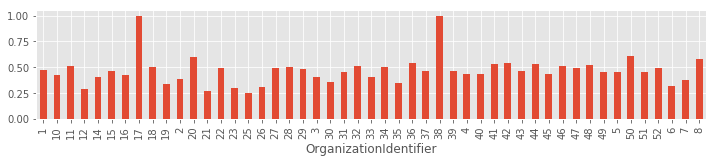

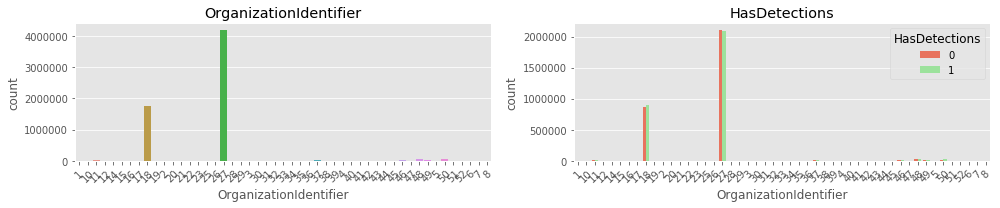

In [107]:
describir('OrganizationIdentifier')

plt.figure(figsize=(12,2))
df.groupby('OrganizationIdentifier')['HasDetections'].mean().plot.bar()

plot_vars('OrganizationIdentifier','HasDetections', cols=True, data=df)

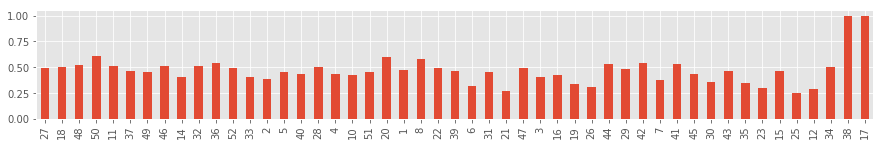

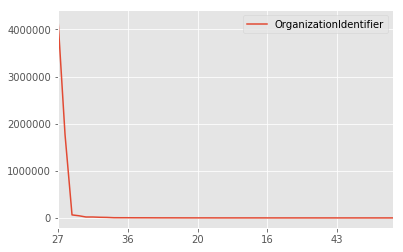

In [114]:
y1 = pd.DataFrame(df['OrganizationIdentifier'].value_counts().nlargest(200))
means = pd.DataFrame(df.groupby('OrganizationIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

pd.DataFrame(df['OrganizationIdentifier'].value_counts(ascending=False)).plot.line()
plt.show()

#### GeoNameIdentifier
- 292 valores únicos

Tipo de dato:  category
Valores únicos:  292
Valores nulos:  213
Porcentaje de valores nulos: 0.00238749544218%


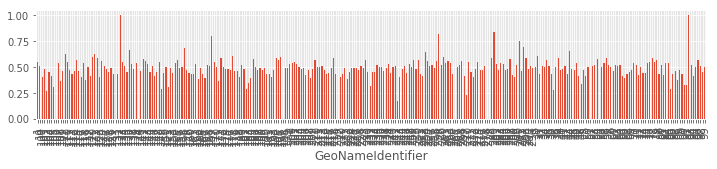

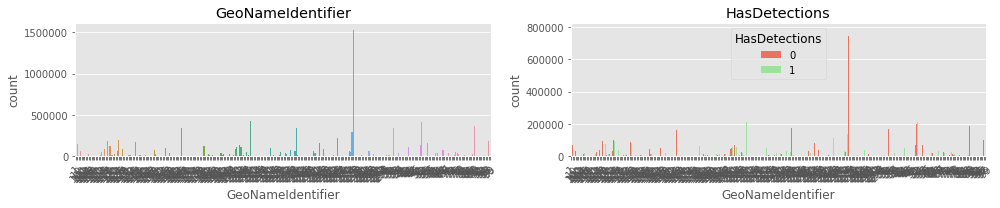

In [136]:
describir('GeoNameIdentifier')

# plt.figure(figsize=(12,2))
# df.groupby('GeoNameIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('GeoNameIdentifier','HasDetections', cols=True, data=df)

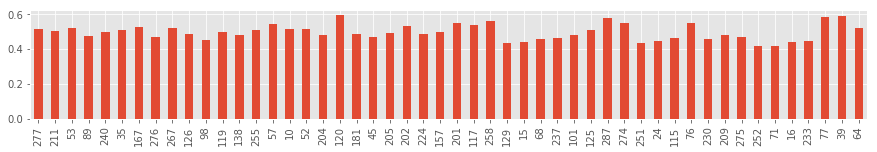

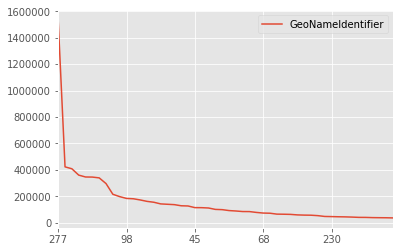

In [145]:
y1 = pd.DataFrame(df['GeoNameIdentifier'].value_counts().nlargest(50))
means = pd.DataFrame(df.groupby('GeoNameIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot.line()
plt.show()

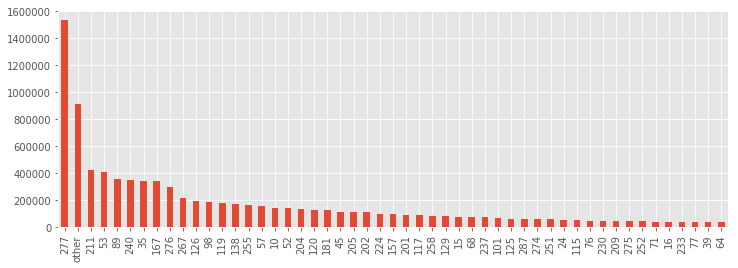

In [148]:
freq = pd.Series(np.where(df['GeoNameIdentifier'].isin(y1.index),df['GeoNameIdentifier'],'other'))
plt.figure(figsize=(12,4))
freq.value_counts().plot.bar()

#### LocaleEnglishNameIdentifier
- 276 valores únicos

In [153]:
describir('LocaleEnglishNameIdentifier')

# plt.figure(figsize=(12,2))
# df.groupby('GeoNameIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('GeoNameIdentifier','HasDetections', cols=True, data=df)

Tipo de dato:  category
Valores únicos:  276
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


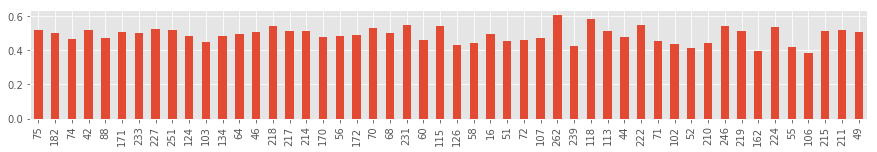

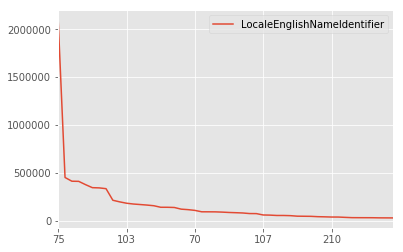

In [172]:
y1 = pd.DataFrame(df['LocaleEnglishNameIdentifier'].value_counts().nlargest(50))
means = pd.DataFrame(df.groupby('LocaleEnglishNameIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot.line()
plt.show()

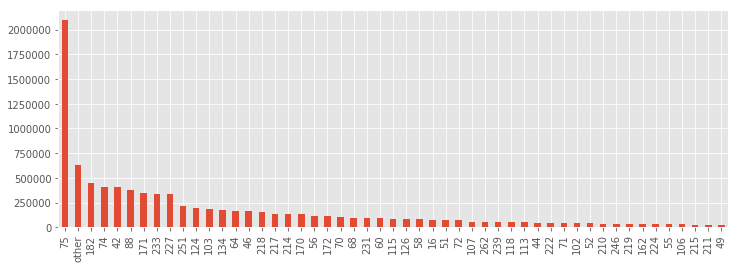

In [173]:
freq = pd.Series(np.where(df['LocaleEnglishNameIdentifier'].isin(y1.index),df['LocaleEnglishNameIdentifier'],'other'))
plt.figure(figsize=(12,4))
freq.value_counts().plot.bar()
plt.show()

#### Platform

Tipo de dato:  category
Valores únicos:  4
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


windows10      8618715
windows8        194508
windows7         93889
windows2016      14371
Name: Platform, dtype: int64


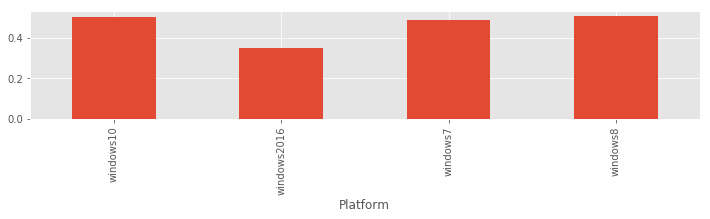

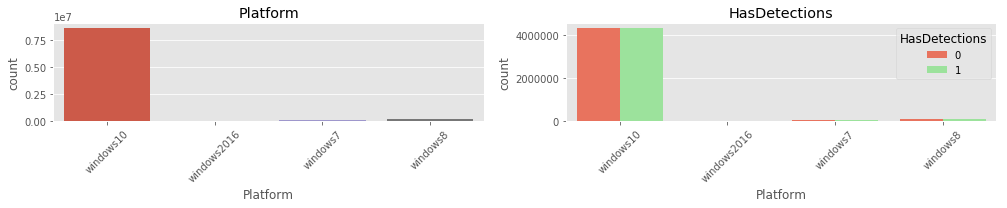

In [176]:
describir('Platform', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Platform')['HasDetections'].mean().plot.bar()

plot_vars('Platform','HasDetections', cols=True, data=df)

#### Processor

Tipo de dato:  category
Valores únicos:  3
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


x64      8105435
x86       815702
arm64        346
Name: Processor, dtype: int64


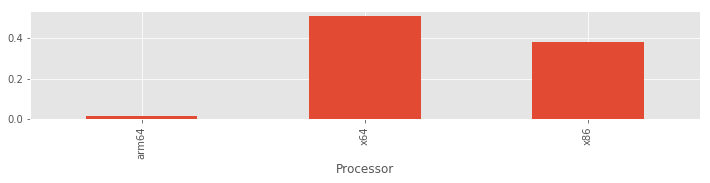

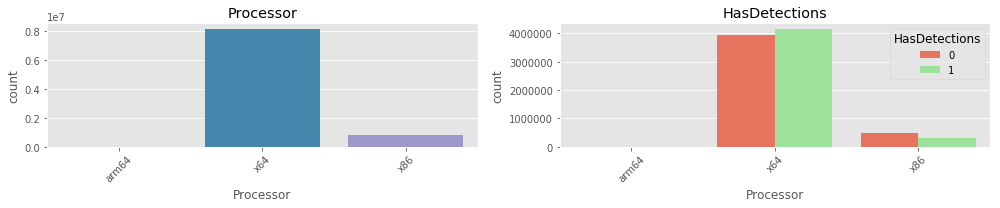

In [177]:
describir('Processor', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Processor')['HasDetections'].mean().plot.bar()

plot_vars('Processor','HasDetections', cols=True, data=df)

#### OsVer
- 3 valores con la mayor cantidad de ocurrencias
- Agrupar en esos tres o en other?

Tipo de dato:  category
Valores únicos:  58
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


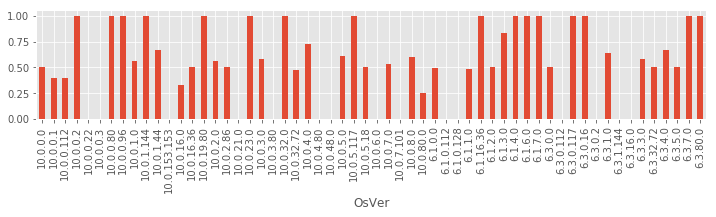

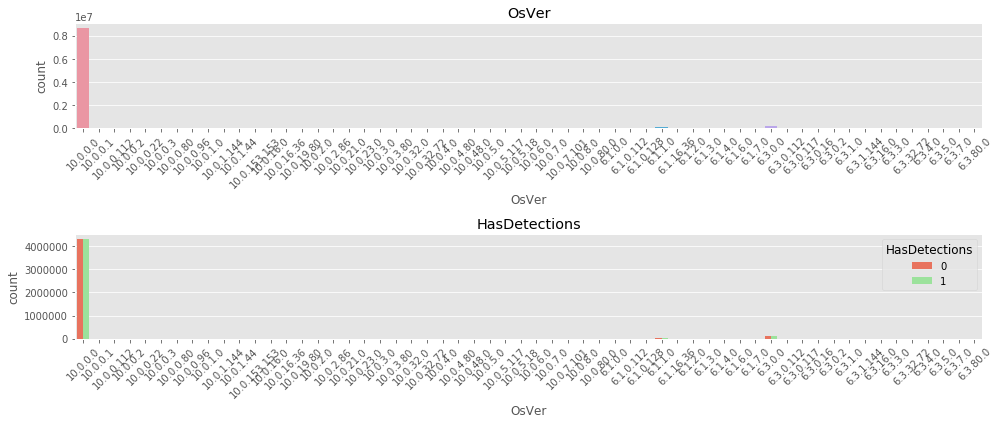

In [225]:
describir('OsVer', vc=False)

plt.figure(figsize=(12,2))
df.groupby('OsVer')['HasDetections'].mean().plot.bar()

plot_vars('OsVer','HasDetections', cols=False, data=df)

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Categories:  3


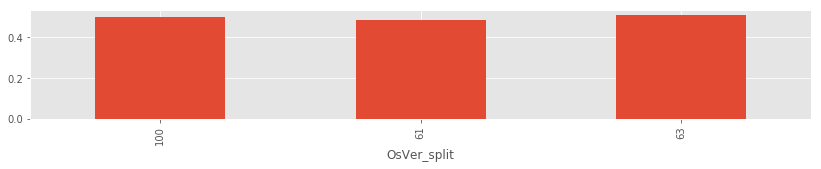

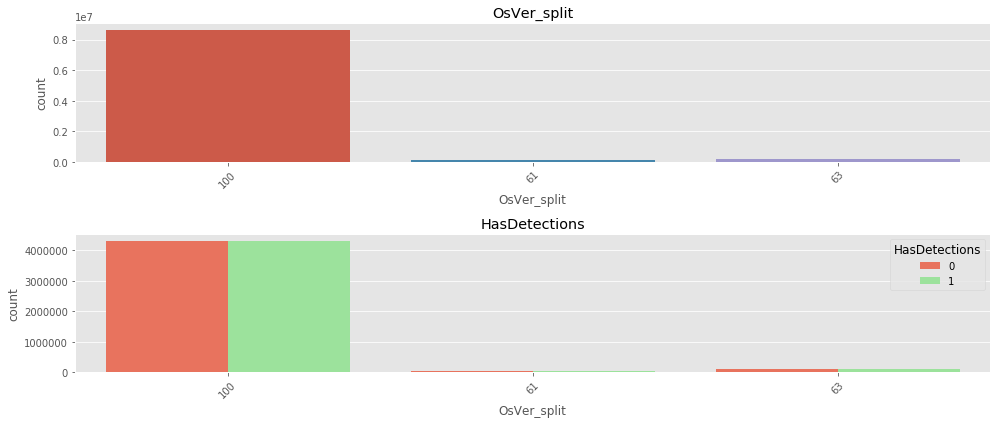

In [224]:
d = df[['OsVer','HasDetections']]
d['OsVer_split'] = d['OsVer'].str.split('.').str.get(0)+d['OsVer'].str.split('.').str.get(1)
d

print('Categories: ', d['OsVer_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('OsVer_split')['HasDetections'].mean().plot.bar()

plot_vars('OsVer_split','HasDetections', cols=False, data=d)

#### OsBuild 
- 76 valores únicos
- Numéricos
- Los primeros 8 tienen la mayoría de los casos

Tipo de dato:  category
Valores únicos:  76
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


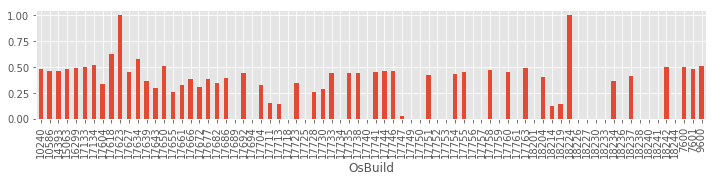

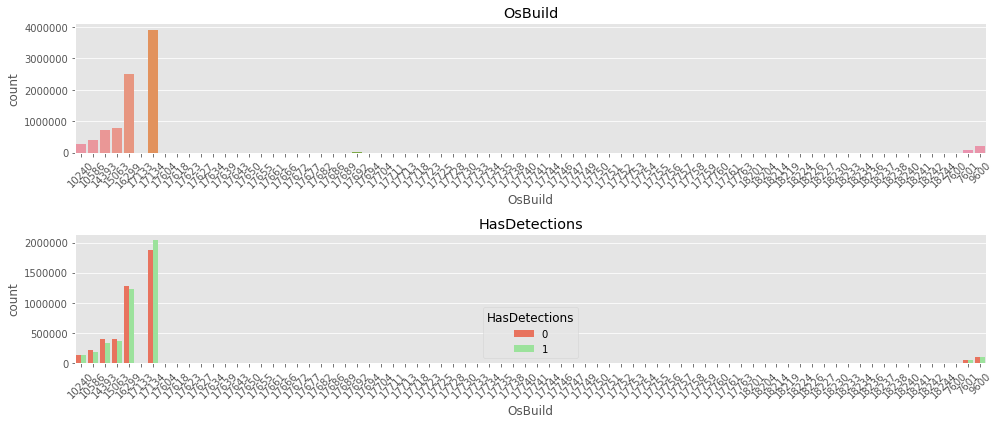

In [32]:
df['OsBuild'] = df['OsBuild'].astype('category')
describir('OsBuild')

plt.figure(figsize=(12,2))
df.groupby('OsBuild')['HasDetections'].mean().plot.bar()

plot_vars('OsBuild','HasDetections', cols=False, data=df)

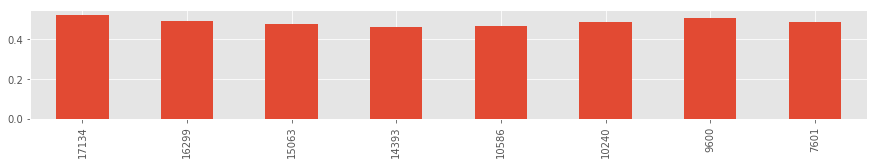

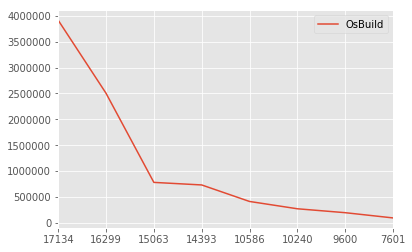

OsBuild
17134  3915521
16299  2503681
15063   780270
14393   730819
10586   411606
10240   270192
9600    194508
7601     93306

In [30]:
y1 = pd.DataFrame(df['OsBuild'].value_counts().nlargest(8))
means = pd.DataFrame(df.groupby('OsBuild')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot()
plt.show()
y1

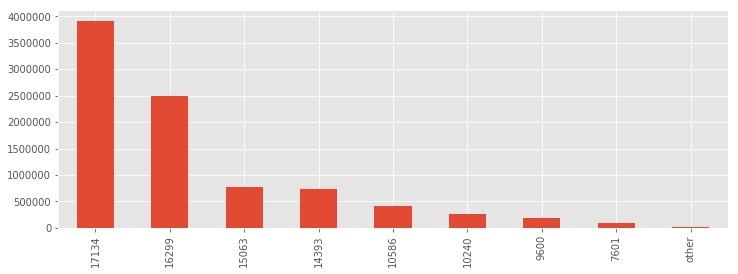

In [31]:
freq = pd.Series(np.where(df['OsBuild'].isin(y1.index),df['OsBuild'],'other'))
plt.figure(figsize=(12,4))
freq.value_counts().plot.bar()
plt.show()

#### OsSuite
Product suite mask for the current operating system
- 14 categorías numéricas
- 2 tienen la mayoría de los valores

Tipo de dato:  category
Valores únicos:  14
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


768    5560661
256    3346251
272      12092
400        793
16         731
305        662
784        198
274         39
144         34
49          17
307          2
528          1
402          1
18           1
Name: OsSuite, dtype: int64


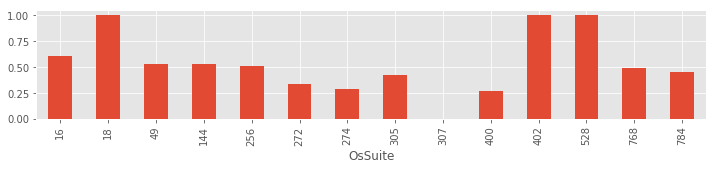

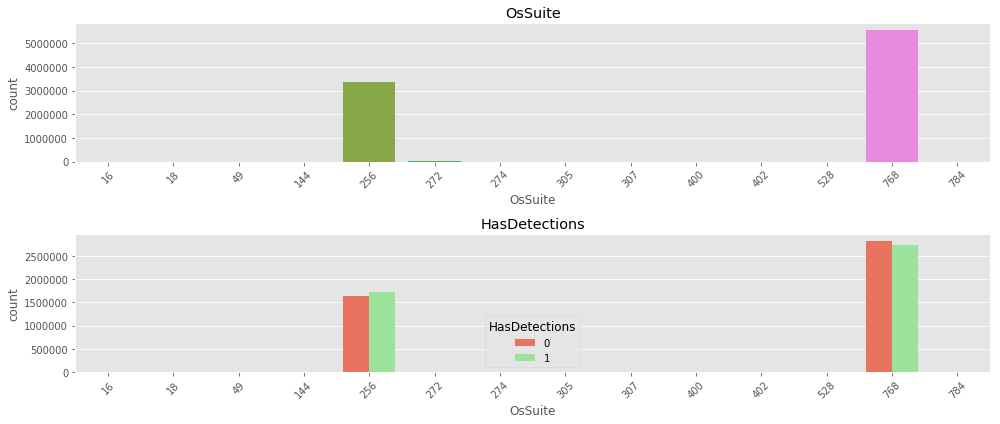

In [35]:
df['OsSuite'] = df['OsSuite'].astype('category')
describir('OsSuite', vc=True)

plt.figure(figsize=(12,2))
df.groupby('OsSuite')['HasDetections'].mean().plot.bar()

plot_vars('OsSuite','HasDetections', cols=False, data=df)

#### OsPlatformSubRelease
Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)

Tipo de dato:  category
Valores únicos:  9
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


rs4           3915526
rs3           2503681
rs2            780270
rs1            730819
th2            411606
th1            270192
windows8.1     194508
windows7        93889
prers5          20992
Name: OsPlatformSubRelease, dtype: int64


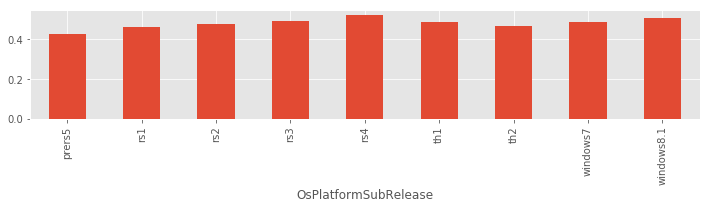

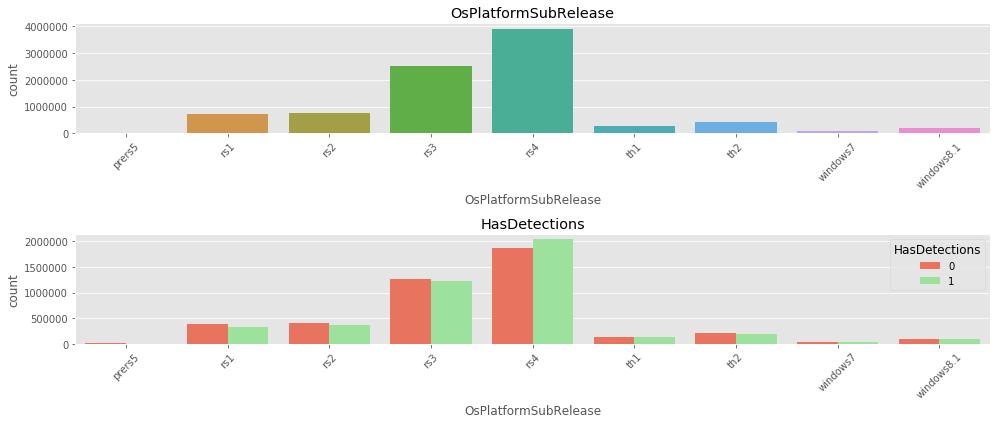

In [37]:
# df['OsPlatformSubRelease'] = df['OsPlatformSubRelease'].astype('category')
describir('OsPlatformSubRelease', vc=True)

plt.figure(figsize=(12,2))
df.groupby('OsPlatformSubRelease')['HasDetections'].mean().plot.bar()

plot_vars('OsPlatformSubRelease','HasDetections', cols=False, data=df)

#### OsBuildLab
Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
- 663 categorías


Tipo de dato:  category
Valores únicos:  663
Valores nulos:  21
Porcentaje de valores nulos: 0.000235386874581%


17134.1.amd64fre.rs4_release.180410-1804                    3658199
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908       1252674
16299.15.amd64fre.rs3_release.170928-1534                    961060
15063.0.amd64fre.rs2_release.170317-1834                     718033
17134.1.x86fre.rs4_release.180410-1804                       257074
16299.15.x86fre.rs3_release.170928-1534                      233449
14393.2189.amd64fre.rs1_release.180329-1711                  193636
10240.17443.amd64fre.th1.170602-2340                         171990
10586.1176.amd64fre.th2_release_sec.170913-1848              148259
15063.0.x86fre.rs2_release.170317-1834                        62237
14393.0.amd64fre.rs1_release.160715-1616                      58292
9600.19101.amd64fre.winblue_ltsb_escrow.180718-1800           56036
9600.19067.amd64fre.winblue_ltsb_escrow.180619-2033           55853
16

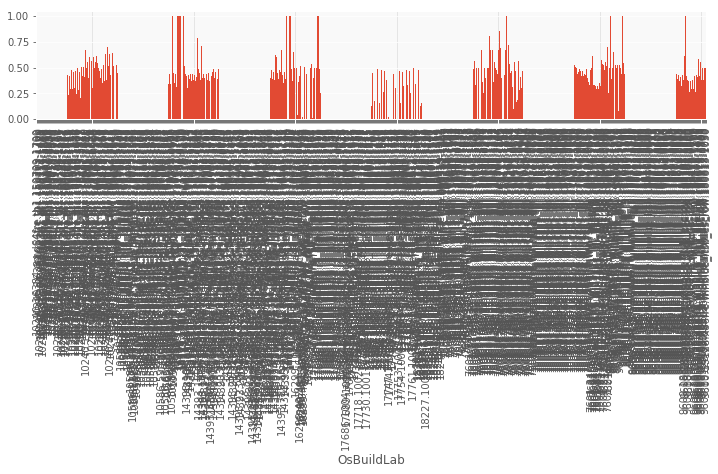

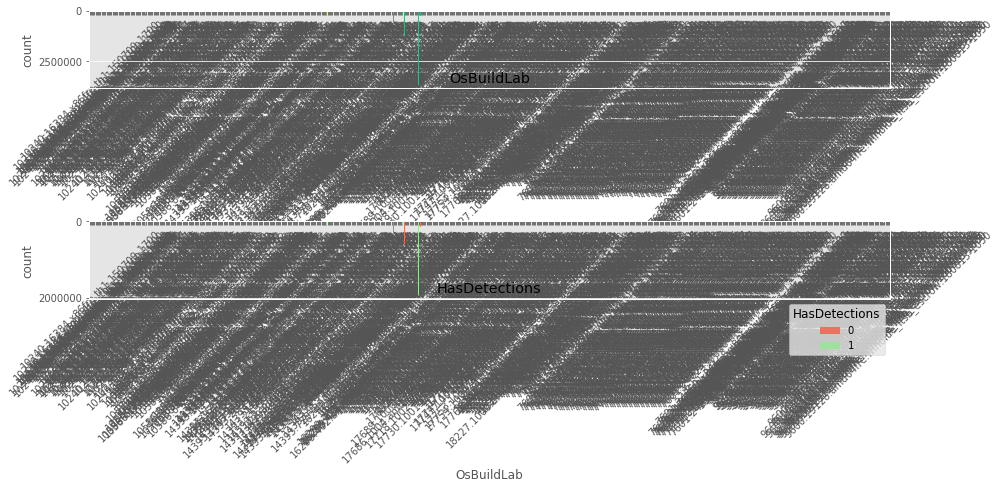

In [38]:
describir('OsBuildLab', vc=True)

plt.figure(figsize=(12,2))
df.groupby('OsBuildLab')['HasDetections'].mean().plot.bar()

plot_vars('OsBuildLab','HasDetections', cols=False, data=df)

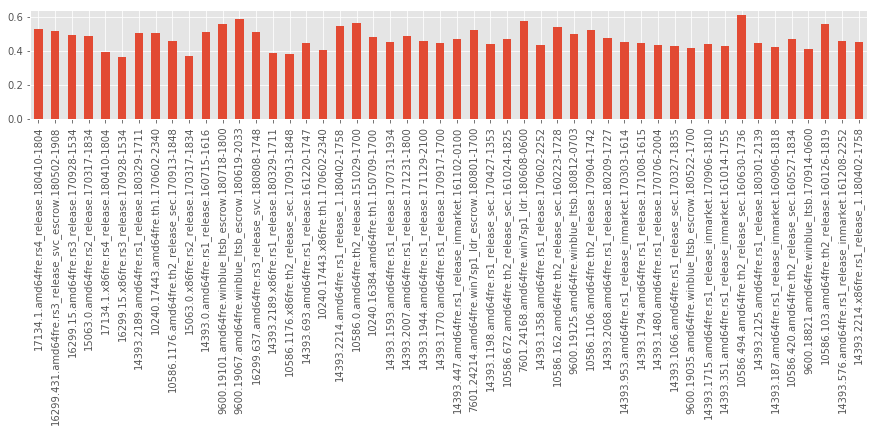

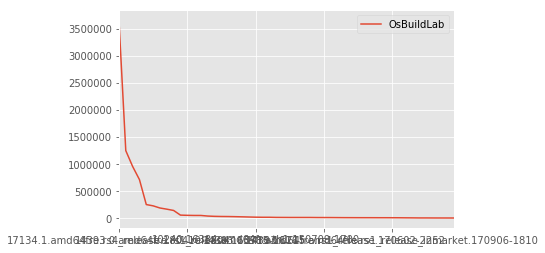

OsBuildLab
17134.1.amd64fre.rs4_release.180410-1804               3658199
16299.431.amd64fre.rs3_release_svc_escrow.18050...     1252674
16299.15.amd64fre.rs3_release.170928-1534               961060
15063.0.amd64fre.rs2_release.170317-1834                718033
17134.1.x86fre.rs4_release.180410-1804                  257074
16299.15.x86fre.rs3_release.170928-1534                 233449
14393.2189.amd64fre.rs1_release.180329-1711             193636
10240.17443.amd64fre.th1.170602-2340                    171990
10586.1176.amd64fre.th2_release_sec.170913-1848         148259
15063.0.x86fre.rs2_release.170317-1834                   62237
14393.0.amd64fre.rs1_release.160715-1616                 58292
9600.19101.amd64fre.winblue_ltsb_escrow.180718-...       56036
9600.19067.amd64fre.winblue_ltsb_escrow.180619-...       55853
16299.637.amd64fre.rs3_release_svc.180808-1748           44817
14393.2189.x86fre.rs1_release.180329-1711                39392
10586.1176.x86fre.th2_release_sec.170913-1848            36929
14393.693.amd64fre.rs1_release.161220-1747               35870
10240.17443.x86fre.th1.170602-2340                       33479
14393.2214.amd64fre.rs1_release_1.180402-1758            30585
10586.0.amd64fre.th2_release.151029-1700                 27240
10240.16384.amd64fre.th1.150709-1700                     24254
14393.1593.amd64fre.rs1_release.170731-1934              22448
14393.2007.amd64fre.rs1_release.171231-1800              22403
14393.1944.amd64fre.rs1_release.171129-2100              19892
14393.1770.amd64fre.rs1_release.170917-1700              19323
14393.447.amd64fre.rs1_release_inmarket.161102-...       18786
7601.24214.amd64fre.win7sp1_ldr_escrow.180801-1700       18780
14393.1198.amd64fre.rs1_release_sec.170427-1353          18657
10586.672.amd64fre.th2_release_sec.161024-1825           18656
7601.24168.amd64fre.win7sp1_ldr.180608-0600              17465
14393.1358.amd64fre.rs1_release.170602-2252              17302
10586.162.amd64fre.th2_release_sec.160223-1728           17114
9600.19125.amd64fre.winblue_ltsb.180812-0703             16254
10586.1106.amd64fre.th2_release.170904-1742              15471
14393.2068.amd64fre.rs1_release.180209-1727              15190
14393.953.amd64fre.rs1_release_inmarket.170303-...       14743
14393.1794.amd64fre.rs1_release.171008-1615              14578
14393.1480.amd64fre.rs1_release.170706-2004              14514
14393.1066.amd64fre.rs1_release_sec.170327-1835          14071
9600.19035.amd64fre.winblue_ltsb_escrow.180522-...       13994
14393.1715.amd64fre.rs1_release_inmarket.170906...       13771
14393.351.amd64fre.rs1_release_inmarket.161014-...       13268
10586.494.amd64fre.th2_release_sec.160630-1736           12113
14393.2125.amd64fre.rs1_release.180301-2139              11300
14393.187.amd64fre.rs1_release_inmarket.160906-...       10114
10586.420.amd64fre.th2_release_sec.160527-1834           10113
9600.18821.amd64fre.winblue_ltsb.170914-0600              9537
10586.103.amd64fre.th2_release.160126-1819                9275
14393.576.amd64fre.rs1_release_inmarket.161208-...        9110
14393.2214.x86fre.rs1_release_1.180402-1758               8766

In [41]:
y1 = pd.DataFrame(df['OsBuildLab'].value_counts().nlargest(50))
means = pd.DataFrame(df.groupby('OsBuildLab')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot()
plt.show()
y1

Categories:  284


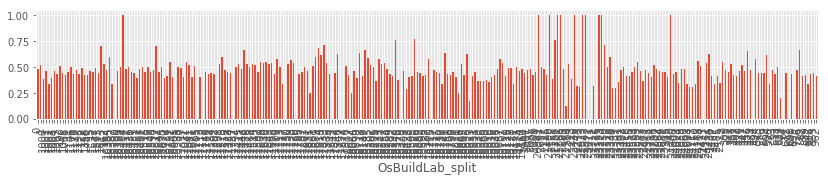

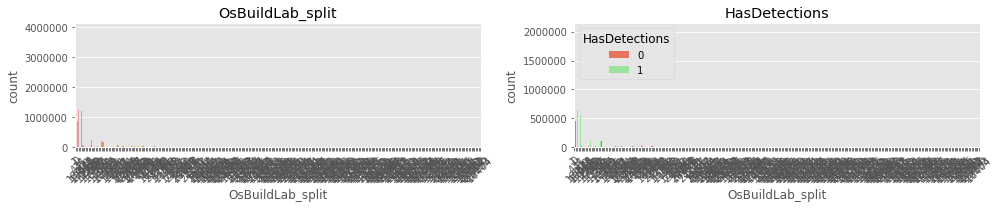

In [65]:
d = df
d['OsBuildLab_split'] = d['OsBuildLab'].str.split('.').str.get(1)
print('Categories: ', d['OsBuildLab_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('OsBuildLab_split')['HasDetections'].mean().plot.bar()

plot_vars('OsBuildLab_split','HasDetections', cols=True, data=d)

Categories:  284


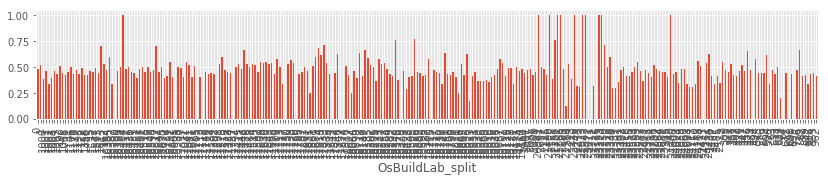

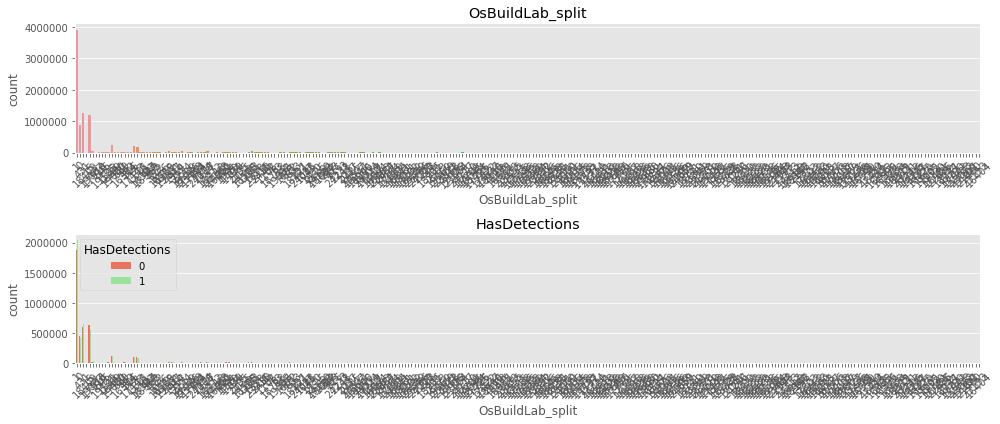

In [43]:
d = df
d['OsBuildLab_split'] = d['OsBuildLab'].str.split('.').str.get(1)
print('Categories: ', d['OsBuildLab_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('OsBuildLab_split')['HasDetections'].mean().plot.bar()

plot_vars('OsBuildLab_split','HasDetections', cols=False, data=d)

Categories:  3


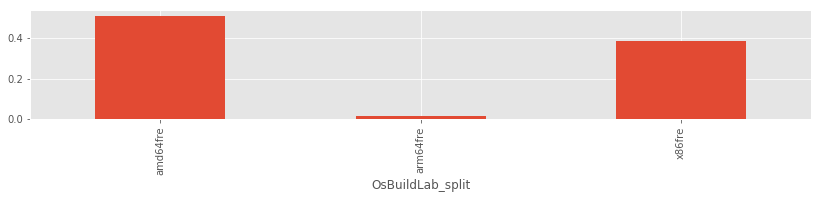

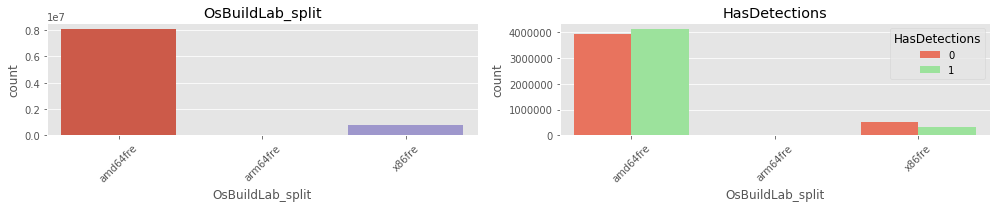

In [63]:
d = df
d['OsBuildLab_split'] = d['OsBuildLab'].str.split('.').str.get(2)
print('Categories: ', d['OsBuildLab_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('OsBuildLab_split')['HasDetections'].mean().plot.bar()

plot_vars('OsBuildLab_split','HasDetections', cols=True, data=d)

Categories:  51


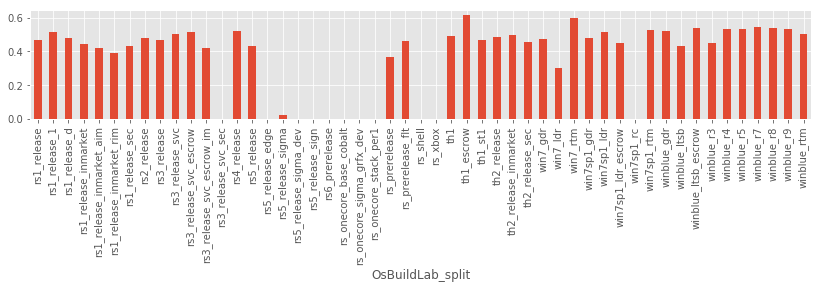

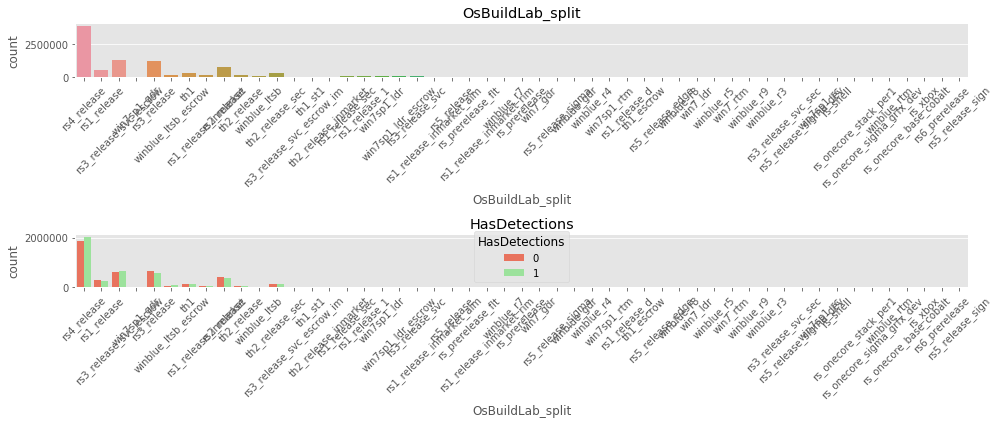

In [51]:
d = df
d['OsBuildLab_split'] = d['OsBuildLab'].str.split('.').str.get(3)
print('Categories: ', d['OsBuildLab_split'].nunique())

plt.figure(figsize=(14,2))
d.groupby('OsBuildLab_split')['HasDetections'].mean().plot.bar()

plot_vars('OsBuildLab_split','HasDetections', cols=False, data=d)

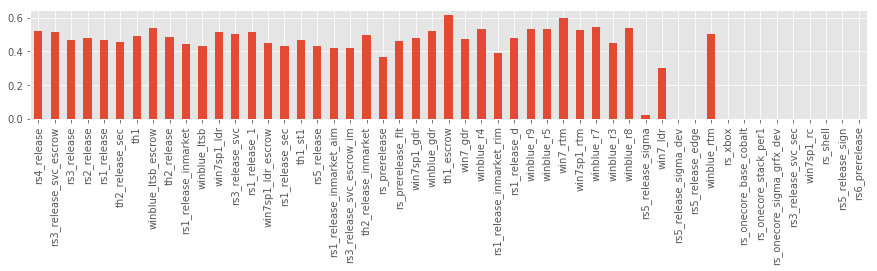

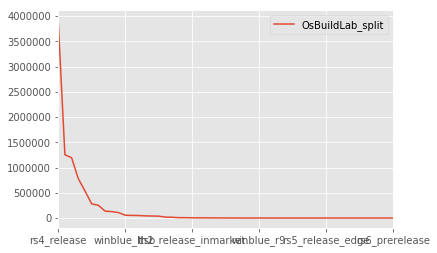

MachineIdentifier
OsBuildLab_split          HasDetections                   
rs1_release               0                         286421
                          1                         249366
rs1_release_1             0                          20632
                          1                          21805
rs1_release_d             0                            120
                          1                            109
rs1_release_inmarket      0                          60314
                          1                          47571
rs1_release_inmarket_aim  0                           4140
                          1                           2976
rs1_release_inmarket_rim  0                            177
                          1                            113
rs1_release_sec           0                          21185
                          1                          15903
rs2_release               0                         406618
                          1                         373652
rs3_release               0                         637760
                          1                         556825
rs3_release_svc           0                          24877
                          1                          24873
rs3_release_svc_escrow    0                         605055
                          1                         647675
rs3_release_svc_escrow_im 0                           3855
                          1                           2756
rs3_release_svc_sec       0                              1
rs4_release               0                        1876592
                          1                        2038914
rs5_release               0                           8497
                          1                           6451
rs5_release_edge          0                              2
...                                                    ...
win7_rtm                  1                             91
win7sp1_gdr               0                           1217
                          1                           1108
win7sp1_ldr               0                          24659
                          1                          26354
win7sp1_ldr_escrow        0                          21973
                          1                          17846
win7sp1_rc                0                              1
win7sp1_rtm               0                             71
                          1                             79
winblue_gdr               0                            419
                          1                            452
winblue_ltsb              0                          31927
                          1                          23916
winblue_ltsb_escrow       0                          63102
                          1                          73642
winblue_r3                0                             60
                          1                             49
winblue_r4                0                            169
                          1                            191
winblue_r5                0                             87
                          1                             98
winblue_r7                0                             53
                          1                             63
winblue_r8                0                             26
                          1                             30
winblue_r9                0                             99
                          1                            113
winblue_rtm               0                              1
                          1                              1

[91 rows x 1 columns]

In [58]:
y1 = pd.DataFrame(d['OsBuildLab_split'].value_counts().nlargest(100))
means = pd.DataFrame(d.groupby('OsBuildLab_split')['HasDetections'].mean())#.plot.bar())

d1 = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d1['HasDetections'].plot.bar()
plt.show()

y1.plot()
plt.show()
pd.DataFrame(d.groupby(['OsBuildLab_split', 'HasDetections'])['MachineIdentifier'].count())

#### SkuEdition

Tipo de dato:  category
Valores únicos:  8
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


Home               5514341
Pro                3224164
Invalid              78054
Education            40694
Enterprise           34357
Enterprise LTSB      20702
Cloud                 5589
Server                3582
Name: SkuEdition, dtype: int64


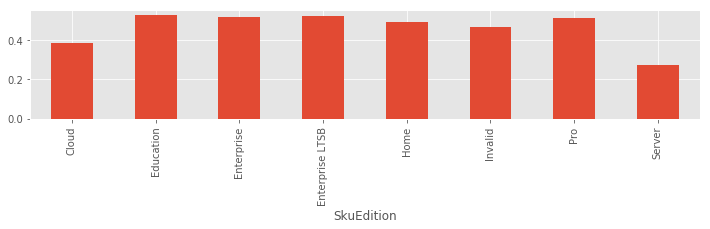

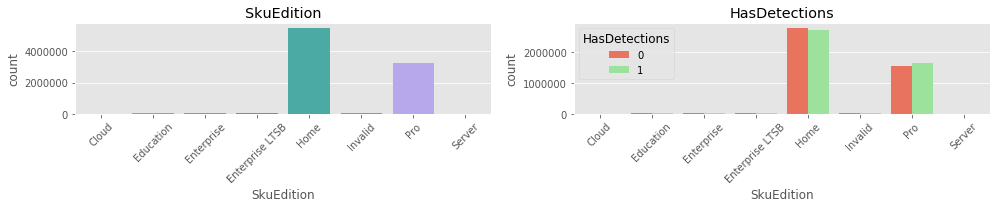

In [62]:
describir('SkuEdition', vc=True)

plt.figure(figsize=(12,2))
df.groupby('SkuEdition')['HasDetections'].mean().plot.bar()

plot_vars('SkuEdition','HasDetections', cols=True, data=df)

#### IsProtected

Tipo de dato:  float16
nada


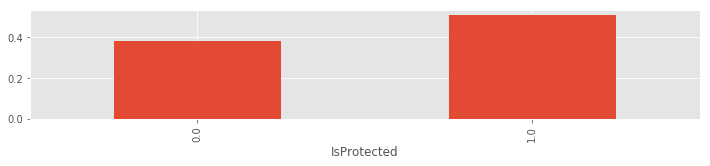

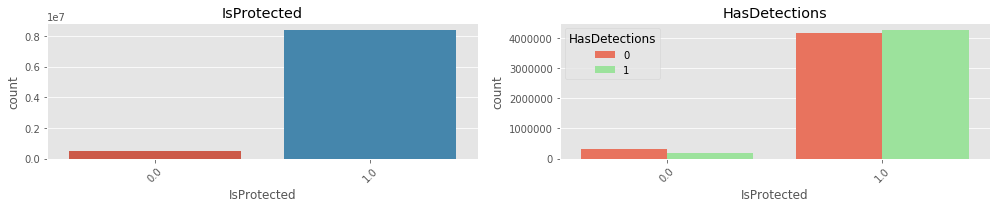

In [66]:
describir('IsProtected', vc=True)

plt.figure(figsize=(12,2))
df.groupby('IsProtected')['HasDetections'].mean().plot.bar()

plot_vars('IsProtected','HasDetections', cols=True, data=df)

#### SMode

In [ ]:
describir('SMode', vc=True)

# plt.figure(figsize=(12,2))
# df.groupby('SMode')['HasDetections'].mean().plot.bar()

# plot_vars('SMode','HasDetections', cols=False, data=df)

#### Firewall

In [ ]:
d = df.loc[:,('MachineIdentifier','HasDetections','Firewall')].pivot_table(index='Firewall', columns='HasDetections'
                                                                            , values='MachineIdentifier'
                                                                            , aggfunc='count')
d.columns = d.columns.astype('object')
print(d)
plt.figure(figsize=(6,3))
sns.heatmap(d,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.show()

Tipo de dato:  category
Valores únicos:  2
Valores nulos:  91350
Porcentaje de valores nulos: 1.02393290443%


1.0    8641014
0.0     189119
Name: Firewall, dtype: int64


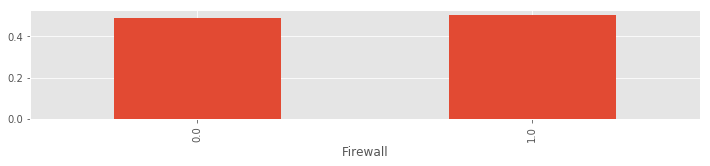

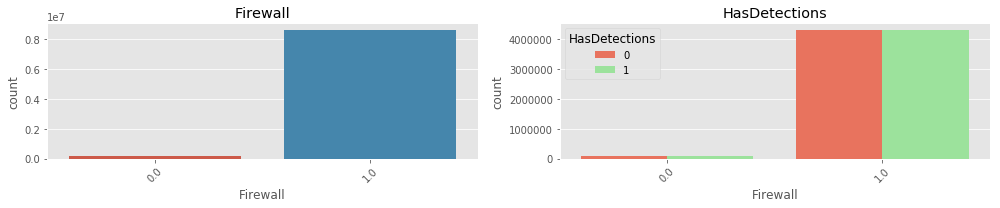

In [72]:
df['Firewall'] = df['Firewall'].astype('category')
describir('Firewall', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Firewall')['HasDetections'].mean().plot.bar()

plot_vars('Firewall','HasDetections', cols=True, data=df)

#### IeVerIdentifier
- 303 valores únicos

In [78]:
df['IeVerIdentifier'] = df['IeVerIdentifier'].astype('category')

describir('IeVerIdentifier', vc=False)

# plt.figure(figsize=(12,2))
# df.groupby('IeVerIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('IeVerIdentifier','HasDetections', cols=False, data=df)

Tipo de dato:  category
Valores únicos:  303
Valores nulos:  58894
Porcentaje de valores nulos: 0.660136885314%


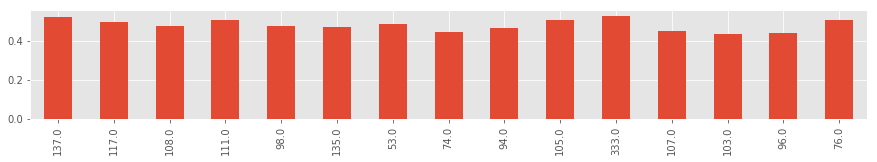

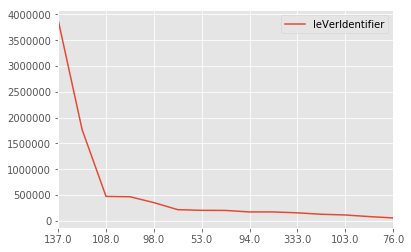

IeVerIdentifier
137.0          3885842
117.0          1767931
108.0           474390
111.0           467828
98.0            354411
135.0           217458
53.0            204952
74.0            202542
94.0            173593
105.0           173448
333.0           156391
107.0           128633
103.0           114952
96.0             83559
76.0             57820

In [80]:
y1 = pd.DataFrame(df['IeVerIdentifier'].value_counts().nlargest(15))
means = pd.DataFrame(df.groupby('IeVerIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot()
plt.show()
y1

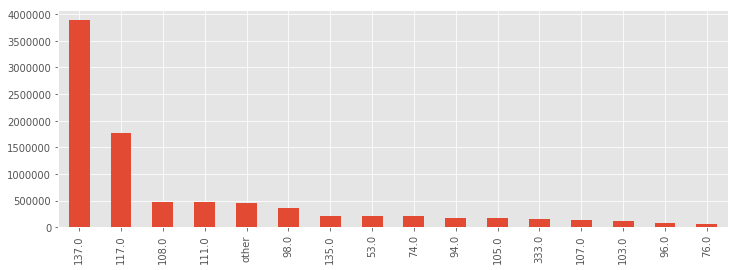

In [81]:
freq = pd.Series(np.where(df['IeVerIdentifier'].isin(y1.index),df['IeVerIdentifier'],'other'))
plt.figure(figsize=(12,4))
freq.value_counts().plot.bar()

#### UacLuaenable
This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC.

Tipo de dato:  float16
nada


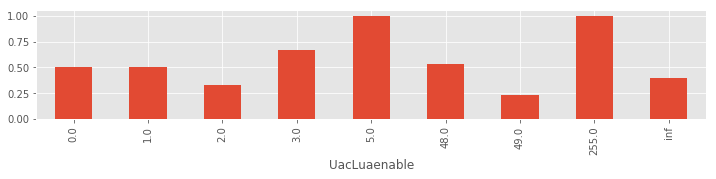

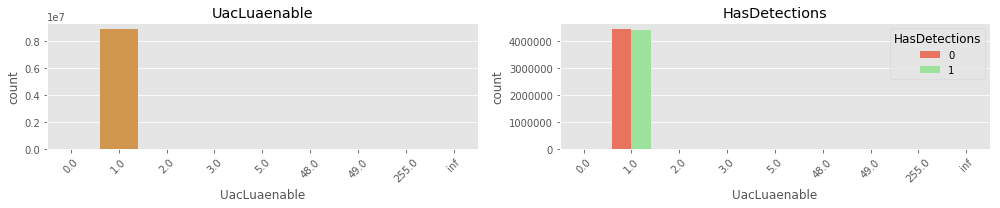

In [74]:
df['IeVerIdentifier'] = df['IeVerIdentifier'].astype('category')
describir('UacLuaenable', vc=True)

plt.figure(figsize=(12,2))
df.groupby('UacLuaenable')['HasDetections'].mean().plot.bar()

plot_vars('UacLuaenable','HasDetections', cols=True, data=df)

#### Census_DeviceFamily
AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for.

Tipo de dato:  category
Valores únicos:  3
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


Windows.Desktop    8907053
Windows.Server       14410
Windows                 20
Name: Census_DeviceFamily, dtype: int64


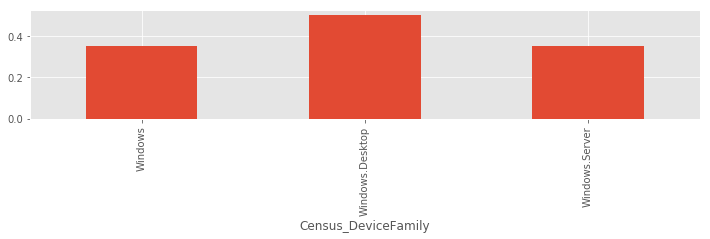

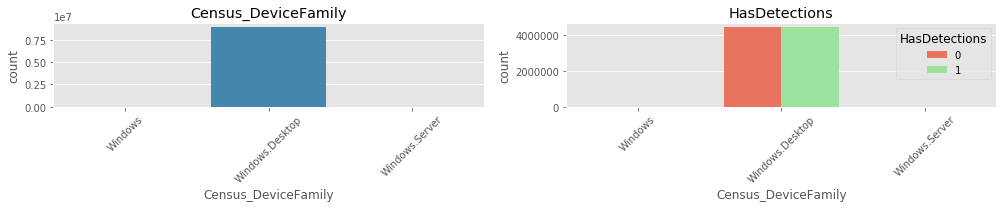

In [86]:
# df['Census_DeviceFamily'] = df['Census_DeviceFamily'].astype('category')

describir('Census_DeviceFamily', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Census_DeviceFamily')['HasDetections'].mean().plot.bar()

plot_vars('Census_DeviceFamily','HasDetections', cols=True, data=df)

#### Census_OEMNameIdentifier
- 3832 categorías


In [85]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_OEMNameIdentifier', vc=True)

# plt.figure(figsize=(12,2))
# df.groupby('Census_OEMNameIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('Census_OEMNameIdentifier','HasDetections', cols=False, data=df)

Tipo de dato:  category
Valores únicos:  3832
Valores nulos:  95478
Porcentaje de valores nulos: 1.07020323863%


2668    1287275
2102    1038567
1443     949531
2206     924349
585      895452
525      842364
4589     310701
4730     304102
1980     285600
4142     200036
4490     139736
4909     138536
3035     134135
3150     129941
3133      79356
530       76377
516       70972
1780      48459
666       47646
3799      45549
3890      43323
4915      39925
2689      34021
1530      27059
778       26774
5080      24785
639       19802
528       18939
2907      18602
2436      17616
         ...   
4577          1
4569          1
4565          1
4562          1
4560          1
243           1
456           1
2432          1
4559          1
4607          1
4616          1
2401          1
2384          1
2368          1
2369          1
465           1
4639          1
4635          1
2381          1
2383          1
2385          1
4618          1
2388          1
2389          1
239   

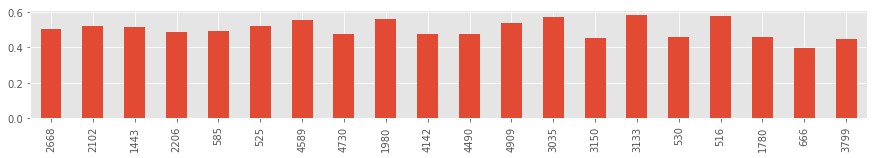

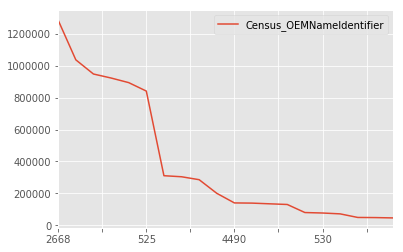

Census_OEMNameIdentifier
2668                   1287275
2102                   1038567
1443                    949531
2206                    924349
585                     895452
525                     842364
4589                    310701
4730                    304102
1980                    285600
4142                    200036
4490                    139736
4909                    138536
3035                    134135
3150                    129941
3133                     79356
530                      76377
516                      70972
1780                     48459
666                      47646
3799                     45549

In [88]:
y1 = pd.DataFrame(df['Census_OEMNameIdentifier'].value_counts().nlargest(20))
means = pd.DataFrame(df.groupby('Census_OEMNameIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot()
plt.show()
y1

#### Census_OEMModelIdentifier

In [90]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_OEMModelIdentifier', vc=True)

# plt.figure(figsize=(12,2))
# df.groupby('Census_OEMNameIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('Census_OEMNameIdentifier','HasDetections', cols=False, data=df)

Tipo de dato:  category
Valores únicos:  175365
Valores nulos:  102233
Porcentaje de valores nulos: 1.14591934996%


313586    304782
242491    263382
317701    139035
317708    115257
228975     79878
188345     70950
245824     69529
241876     68263
244755     49630
248045     43757
313507     37923
256480     34270
241805     32686
251630     30775
171320     28851
246715     28545
241911     27833
229920     26812
228726     26715
256585     26570
313504     23666
313506     23140
248395     22834
229929     22219
256581     21505
256682     21429
256477     21250
171222     19854
229904     19468
35255      19283
           ...  
22326          1
223260         1
223261         1
48157          1
223276         1
48154          1
48151          1
22320          1
2232           1
223194         1
223138         1
22312          1
223122         1
223125         1
223128         1
22313          1
223133         1
223136         1
223137         1
223147         1
22319          1

#### Census_ProcessorCoreCount
- Campo numérico

In [125]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_ProcessorCoreCount', vc=True)

# plt.boxplot(df['Census_ProcessorCoreCount'])#, df['HasDetections'])
# y1 = pd.DataFrame(df['Census_OEMNameIdentifier'].value_counts().nlargest(20))
print(pd.DataFrame(df.groupby('HasDetections')['Census_ProcessorCoreCount'].mean()))

print((df.groupby('HasDetections')['Census_ProcessorCoreCount']).sum())
# df['Census_ProcessorCoreCount'].sort_values(ascending=False).plot()
# d = (y1.merge(means, how='inner', left_index=True, right_index=True))
# plt.figure(figsize=(15,2))
# d['HasDetections'].plot.bar()
# plt.show()

# y1.plot()
# plt.show()
# y1

sum(np.isinf(df['Census_ProcessorCoreCount']))

Tipo de dato:  float32
nada
               Census_ProcessorCoreCount
HasDetections                           
0                               3.876709
1                               4.102870
HasDetections
0    17227224.0
1    18201978.0
Name: Census_ProcessorCoreCount, dtype: float32


0

#### Census_ProcessorManufacturerIdentifier
- 7 categorías

Tipo de dato:  category
Valores únicos:  7
Valores nulos:  41313
Porcentaje de valores nulos: 0.463073235694%


5     7839318
1     1040292
10        339
3         218
9           1
7           1
4           1
Name: Census_ProcessorManufacturerIdentifier, dtype: int64


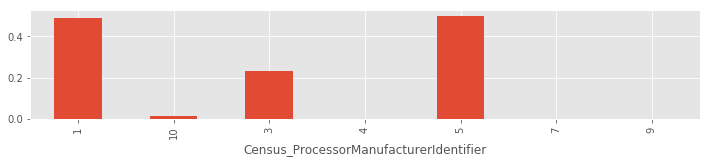

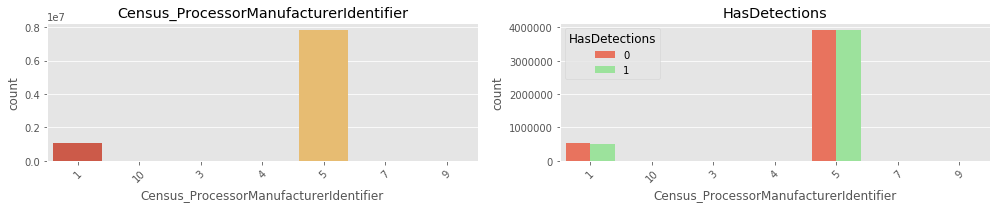

In [128]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_ProcessorManufacturerIdentifier', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Census_ProcessorManufacturerIdentifier')['HasDetections'].mean().plot.bar()

plot_vars('Census_ProcessorManufacturerIdentifier','HasDetections', cols=True, data=df)

#### Census_ProcessorModelIdentifier
- 3428 categorías

In [131]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_ProcessorModelIdentifier', vc=False)

# plt.figure(figsize=(12,2))
# df.groupby('Census_ProcessorModelIdentifier')['HasDetections'].mean().plot.bar()

# plot_vars('Census_ProcessorModelIdentifier','HasDetections', cols=False, data=df)

Tipo de dato:  category
Valores únicos:  3428
Valores nulos:  41343
Porcentaje de valores nulos: 0.463409502658%


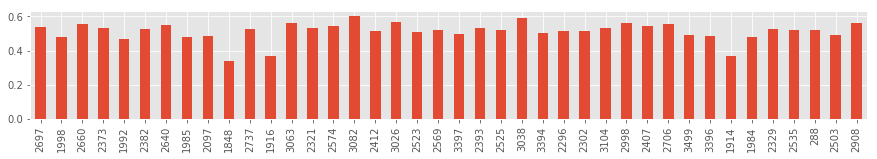

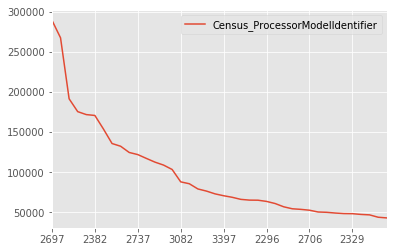

Census_ProcessorModelIdentifier
2697                           289283
1998                           267397
2660                           191392
2373                           175407
1992                           171728
2382                           170651
2640                           153719
1985                           135682
2097                           132299
1848                           124533
2737                           121892
1916                           117135
3063                           112499
2321                           108826
2574                           103348
3082                            87917
2412                            85587
3026                            79081
2523                            76417
2569                            72953
3397                            70632
2393                            68689
2525                            66110
3038                            65185
3394                            65066
2296                            63559
2302                            60919
3104                            56843
2998                            54376
2407                            53647
2706                            52588
3499                            50382
3396                            49979
1914                            49075
1984                            48403
2329                            48270
2535                            47346
288                             46790
2503                            43843
2908                            42996

In [136]:
y1 = pd.DataFrame(df['Census_ProcessorModelIdentifier'].value_counts().nlargest(40))
means = pd.DataFrame(df.groupby('Census_ProcessorModelIdentifier')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot()
plt.show()
y1

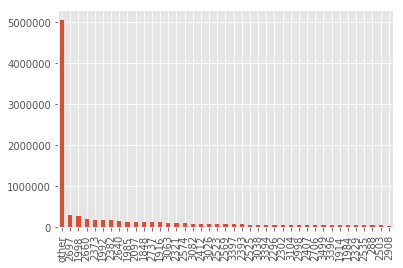

In [137]:
freq = pd.Series(np.where(df['Census_ProcessorModelIdentifier'].isin(y1.index),df['Census_ProcessorModelIdentifier'],'other'))
freq.value_counts().plot.bar()

#### Census_ProcessorClass
- 3 valores únicos
- La mayoría son nulos

Tipo de dato:  category
Valores únicos:  3
Valores nulos:  8884852
Porcentaje de valores nulos: 99.5894068284%


mid     20914
low      9621
high     6096
Name: Census_ProcessorClass, dtype: int64


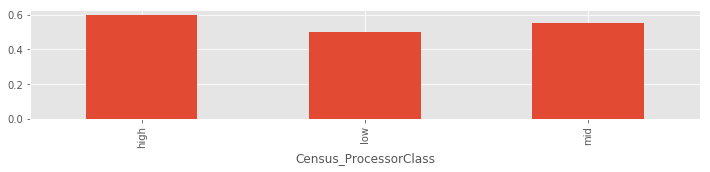

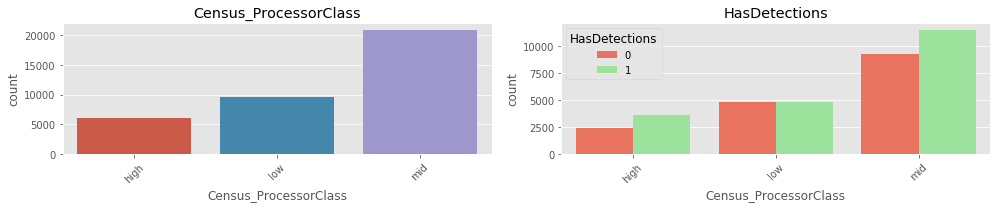

In [139]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_ProcessorClass', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Census_ProcessorClass')['HasDetections'].mean().plot.bar()

plot_vars('Census_ProcessorClass','HasDetections', cols=True, data=df)

#### Census_PrimaryDiskTotalCapacity

In [146]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_PrimaryDiskTotalCapacity', vc=True)

# plt.figure(figsize=(12,2))
# df.groupby('Census_PrimaryDiskTotalCapacity')['HasDetections'].mean().plot.bar()

# plot_vars('Census_PrimaryDiskTotalCapacity','HasDetections', cols=False, data=df)

Tipo de dato:  float32
nada


In [147]:
print(pd.DataFrame(df.groupby('HasDetections')['Census_PrimaryDiskTotalCapacity'].mean()))
print((df.groupby('HasDetections')['Census_PrimaryDiskTotalCapacity']).sum())

               Census_PrimaryDiskTotalCapacity
HasDetections                                 
0                                   2334064.75
1                                   3845071.75
HasDetections
0    1.035685e+13
1    1.703832e+13
Name: Census_PrimaryDiskTotalCapacity, dtype: float32


In [ ]:
Census_PrimaryDiskTypeName

Tipo de dato:  category
Valores únicos:  4
Valores nulos:  12844
Porcentaje de valores nulos: 0.143967096053%


HDD            5806804
SSD            2466808
UNKNOWN         358251
Unspecified     276776
Name: Census_PrimaryDiskTypeName, dtype: int64


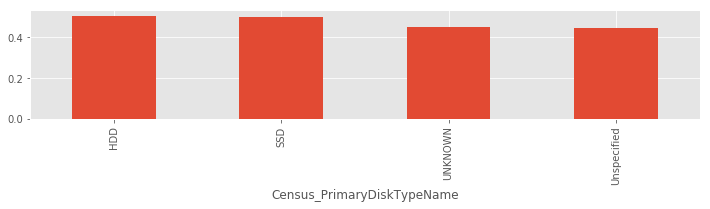

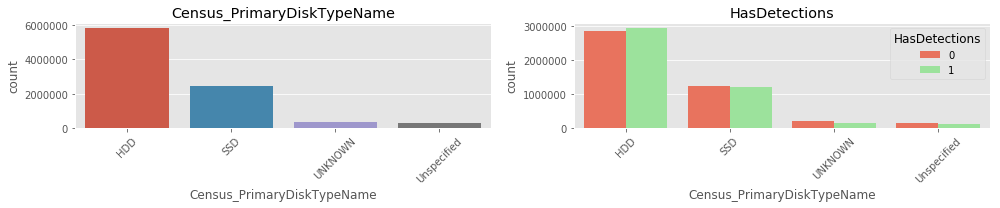

In [149]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_PrimaryDiskTypeName', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Census_PrimaryDiskTypeName')['HasDetections'].mean().plot.bar()

plot_vars('Census_PrimaryDiskTypeName','HasDetections', cols=True, data=df)

#### Census_SystemVolumeTotalCapacity

In [150]:
# df['Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')

describir('Census_SystemVolumeTotalCapacity', vc=True)

# plt.figure(figsize=(12,2))
# df.groupby('Census_SystemVolumeTotalCapacity')['HasDetections'].mean().plot.bar()

# plot_vars('Census_SystemVolumeTotalCapacity','HasDetections', cols=False, data=df)

Tipo de dato:  float32
nada


In [151]:
print(pd.DataFrame(df.groupby('HasDetections')['Census_SystemVolumeTotalCapacity'].mean()))
print((df.groupby('HasDetections')['Census_SystemVolumeTotalCapacity']).sum())

               Census_SystemVolumeTotalCapacity
HasDetections                                  
0                                  372652.31250
1                                  382090.71875
HasDetections
0    1.653555e+12
1    1.693129e+12
Name: Census_SystemVolumeTotalCapacity, dtype: float32


#### Census_HasOpticalDiskDrive

Tipo de dato:  category
Valores únicos:  2
Valores nulos:  0
Porcentaje de valores nulos: 0.0%


0    8232858
1     688625
Name: Census_HasOpticalDiskDrive, dtype: int64


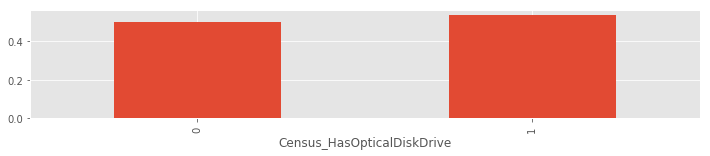

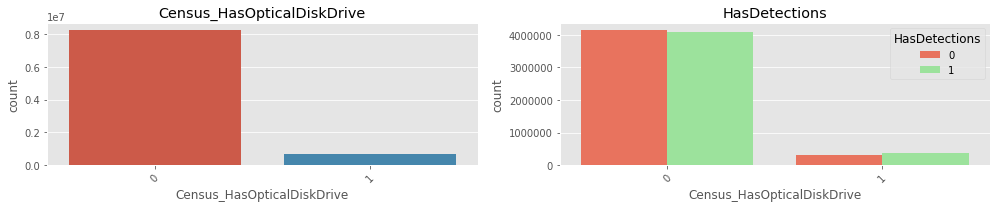

In [154]:
df['Census_HasOpticalDiskDrive'] = df['Census_HasOpticalDiskDrive'].astype('category')

describir('Census_HasOpticalDiskDrive', vc=True)

plt.figure(figsize=(12,2))
df.groupby('Census_HasOpticalDiskDrive')['HasDetections'].mean().plot.bar()

plot_vars('Census_HasOpticalDiskDrive','HasDetections', cols=True, data=df)

#### Census_TotalPhysicalRAM 

In [155]:
# df['Census_HasOpticalDiskDrive'] = df['Census_HasOpticalDiskDrive'].astype('category')

describir('Census_TotalPhysicalRAM', vc=True)

# plt.figure(figsize=(12,2))
# df.groupby('Census_TotalPhysicalRAM')['HasDetections'].mean().plot.bar()

# plot_vars('Census_TotalPhysicalRAM','HasDetections', cols=True, data=df)

Tipo de dato:  float16
nada


In [160]:
print(pd.DataFrame(df.groupby('HasDetections')['Census_InternalBatteryNumberOfCharges'].mean()))
print((df.groupby('HasDetections')['Census_InternalBatteryNumberOfCharges']).sum())

               Census_InternalBatteryNumberOfCharges
HasDetections                                       
0                                       1.085849e+09
1                                       1.161916e+09
HasDetections
0    4.710241e+15
1    5.013538e+15
Name: Census_InternalBatteryNumberOfCharges, dtype: float64


#### Census_ChassisTypeName

In [161]:
# df['Census_HasOpticalDiskDrive'] = df['Census_HasOpticalDiskDrive'].astype('category')

describir('Census_ChassisTypeName', vc=True)

# plt.figure(figsize=(12,2))
# df.groupby('Census_ChassisTypeName')['HasDetections'].mean().plot.bar()

# plot_vars('Census_ChassisTypeName','HasDetections', cols=True, data=df)

Tipo de dato:  category
Valores únicos:  52
Valores nulos:  623
Porcentaje de valores nulos: 0.00698314394591%


Notebook               5248812
Desktop                1872125
Laptop                  685581
Portable                360903
AllinOne                204295
MiniTower                85127
Convertible              84472
Other                    75782
UNKNOWN                  67212
Detachable               51466
LowProfileDesktop        50072
HandHeld                 46009
SpaceSaving              29070
Tablet                   13630
Tower                    12549
Unknown                  10011
MainServerChassis         9545
MiniPC                    4433
LunchBox                  3971
RackMountChassis          3410
SubNotebook                807
BusExpansionChassis        720
30                         243
StickPC                    142
0                          133
MultisystemChassis          61
Blade                       52
35                          50
PizzaBox           

In [ ]:
y1 = pd.DataFrame(df['OsBuild'].value_counts().nlargest(8))
means = pd.DataFrame(df.groupby('OsBuild')['HasDetections'].mean())#.plot.bar())

d = (y1.merge(means, how='inner', left_index=True, right_index=True))
plt.figure(figsize=(15,2))
d['HasDetections'].plot.bar()
plt.show()

y1.plot()
plt.show()
y1